In [1]:
import pandas as pd
import numpy as np
from glob import glob
import re
import nltk
import plotly_express as px
import configparser

In [2]:
config = configparser.ConfigParser()
config.read("../env-sample.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [3]:
source_files = f'{data_home}/eta_project/Hawthorne'

In [4]:
import sys
sys.path.append(local_lib)
import textparser

In [5]:
OHCO = ['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num']
bags = dict(
    CHAPS = OHCO[:2],
    BOOKS = OHCO[:1]
)

In [6]:
clip_pats = [
    r"\*\*\*\s*START OF",
    r"\*\*\*\s*END OF"
]

ohco_pat_list = [
    (0, rf"(\bCHAPTER\s*[IVXLCDM]+\b|THE END OF THE MANUSCRIPT)"),
    (1, rf"(^\s*CHAPTER\s*[IVXLCDM]+\.|CHAPTER THE LAST)"),
    (2, rf"^\s*CHAPTER\s*[IVXLCDM]+"),
    (3,   rf"^[IVXLCM]+\.\s*.*$"), 
    (4,   rf"^\s*[IVXLCM]+\s*.$"), 
    (5, rf"^\s*CHAPTER\s[IVXLCM]+\s*$"),
    (6,  rf"(^\s*CHAPTER\s*[IVXLCDM]+|CONCLUSION)"),
    (7, rf"^\s*[IVXLCM]+\s*.$") 
]

In [7]:
source_file_list = sorted(glob(f"{source_files}/*.*"))

In [8]:
book_data = []
for source_file_path in source_file_list:
    book_title = source_file_path.split('/')[-1].split('-')[0].replace('_', ' ').replace('.txt', '')
    book_data.append((source_file_path, book_title))

In [9]:
book_data

[("/Users/matthewbonner/Desktop/DS5001/data/eta_project/Hawthorne/A Connecticut_Yankee_in_King_Arthur's_Court.txt",
  "A Connecticut Yankee in King Arthur's Court"),
 ('/Users/matthewbonner/Desktop/DS5001/data/eta_project/Hawthorne/Adventures_of_Huckleberry_Finn.txt',
  'Adventures of Huckleberry Finn'),
 ('/Users/matthewbonner/Desktop/DS5001/data/eta_project/Hawthorne/Adventures_of_Tom_Sawyer.txt',
  'Adventures of Tom Sawyer'),
 ('/Users/matthewbonner/Desktop/DS5001/data/eta_project/Hawthorne/The_Blithedale_Romance.txt',
  'The Blithedale Romance'),
 ('/Users/matthewbonner/Desktop/DS5001/data/eta_project/Hawthorne/The_House_of_the_Seven_Gables.txt',
  'The House of the Seven Gables'),
 ('/Users/matthewbonner/Desktop/DS5001/data/eta_project/Hawthorne/The_Marble_Faun.txt',
  'The Marble Faun'),
 ('/Users/matthewbonner/Desktop/DS5001/data/eta_project/Hawthorne/The_Prince_and_the_Pauper.txt',
  'The Prince and the Pauper'),
 ('/Users/matthewbonner/Desktop/DS5001/data/eta_project/Hawthorn

In [10]:
LIB = pd.DataFrame(book_data, columns=['source_file_path','raw_title'])

In [11]:
LIB

source_file_path  \
0  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
1  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
2  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
3  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
4  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
5  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
6  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
7  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   

                                     raw_title  
0  A Connecticut Yankee in King Arthur's Court  
1               Adventures of Huckleberry Finn  
2                     Adventures of Tom Sawyer  
3                       The Blithedale Romance  
4                The House of the Seven Gables  
5                              The Marble Faun  
6                    The Prince and the Pauper  
7                           The Scarlet Letter

In [12]:
AUTHORS = ["TWAIN", "TWAIN", "TWAIN", "HAWTHORNE", "HAWTHORNE", "HAWTHORNE", "TWAIN", "HAWTHORNE"]

In [13]:
LIB['author'] = AUTHORS

In [14]:
LIB['chap_regex'] = LIB.index.map(pd.Series({x[0]:x[1] for x in ohco_pat_list}))

In [15]:
LIB

source_file_path  \
0  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
1  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
2  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
3  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
4  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
5  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
6  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
7  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   

                                     raw_title     author  \
0  A Connecticut Yankee in King Arthur's Court      TWAIN   
1               Adventures of Huckleberry Finn      TWAIN   
2                     Adventures of Tom Sawyer      TWAIN   
3                       The Blithedale Romance  HAWTHORNE   
4                The House of the Seven Gables  HAWTHORNE   
5                              The Marble Faun  HAWTHORNE   
6                    The Prince and the Pauper      TWAIN   
7                           The Scarlet Letter  HAWTHORNE   

                                          chap_regex  
0  (\bCHAPTER\s*[IVXLCDM]+\b|THE END OF THE MANUS...  
1      (^\s*CHAPTER\s*[IVXLCDM]+\.|CHAPTER THE LAST)  
2                           ^\s*CHAPTER\s*[IVXLCDM]+  
3                                 ^[IVXLCM]+\.\s*.*$  
4                                 ^\s*[IVXLCM]+\s*.$  
5                         ^\s*CHAPTER\s[IVXLCM]+\s*$  
6              (^\s*CHAPTER\s*[IVXLCDM]+|CONCLUSION)  
7                                 ^\s*[IVXLCM]+\s*.$

In [16]:
from textparser import TextParser

In [17]:
LIB = LIB.reset_index() 

In [18]:
LIB = LIB.rename(columns={'index': 'book_id', 'raw_title': 'title'})

In [19]:
LIB["date"] = ["1889", "1884", "1876", "1852", "1851", "1860", "1881", "1850"]

In [20]:
LIB

book_id                                   source_file_path  \
0        0  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
1        1  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
2        2  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
3        3  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
4        4  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
5        5  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
6        6  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
7        7  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   

                                         title     author  \
0  A Connecticut Yankee in King Arthur's Court      TWAIN   
1               Adventures of Huckleberry Finn      TWAIN   
2                     Adventures of Tom Sawyer      TWAIN   
3                       The Blithedale Romance  HAWTHORNE   
4                The House of the Seven Gables  HAWTHORNE   
5                              The Marble Faun  HAWTHORNE   
6                    The Prince and the Pauper      TWAIN   
7                           The Scarlet Letter  HAWTHORNE   

                                          chap_regex  date  
0  (\bCHAPTER\s*[IVXLCDM]+\b|THE END OF THE MANUS...  1889  
1      (^\s*CHAPTER\s*[IVXLCDM]+\.|CHAPTER THE LAST)  1884  
2                           ^\s*CHAPTER\s*[IVXLCDM]+  1876  
3                                 ^[IVXLCM]+\.\s*.*$  1852  
4                                 ^\s*[IVXLCM]+\s*.$  1851  
5                         ^\s*CHAPTER\s[IVXLCM]+\s*$  1860  
6              (^\s*CHAPTER\s*[IVXLCDM]+|CONCLUSION)  1881  
7                                 ^\s*[IVXLCM]+\s*.$  1850

In [21]:
def tokenize_collection(LIB):

    clip_pats = [
        r"\*\*\*\s*START OF",
        r"\*\*\*\s*END OF"
    ]

    books = []
    for book_id in LIB.index:

        # Announce
        print("Tokenizing", book_id, LIB.loc[book_id].title)

        # Define vars
        chap_regex = LIB.loc[book_id].chap_regex
        ohco_pats = [('chap', chap_regex, 'm')]
        src_file_path = LIB.loc[book_id].source_file_path

        # Create object
        text = TextParser(src_file_path, ohco_pats=ohco_pats, clip_pats=clip_pats, use_nltk=True)

        # Define parameters
        text.verbose = True
        text.strip_hyphens = True
        text.strip_whitespace = True

        # Parse
        text.import_source().parse_tokens();

        # Name things
        text.TOKENS['book_id'] = book_id
        text.TOKENS = text.TOKENS.reset_index().set_index(['book_id'] + text.OHCO)

        # Add to list
        books.append(text.TOKENS)
        
    # Combine into a single dataframe
    CORPUS = pd.concat(books).sort_index()

    # Clean up
    del(books)
    del(text)
        
    print("Done")
        
    return CORPUS

In [22]:
CORPUS = tokenize_collection(LIB)

Tokenizing 0 A Connecticut Yankee in King Arthur's Court
Importing  /Users/matthewbonner/Desktop/DS5001/data/eta_project/Hawthorne/A Connecticut_Yankee_in_King_Arthur's_Court.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone (\bCHAPTER\s*[IVXLCDM]+\b|THE END OF THE MANUSCRIPT)
line_str chap_str
Index(['chap_str'], dtype='object')
Parsing OHCO level 1 para_num by delimitter \n\n
Parsing OHCO level 2 sent_num by NLTK model


/Users/matthewbonner/Desktop/DS5001/output/textparser.py:132: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  div_lines = self.TOKENS[src_col].str.contains(div_pat, regex=True, case=True) # TODO: Parametize case


Parsing OHCO level 3 token_num by NLTK model
Tokenizing 1 Adventures of Huckleberry Finn
Importing  /Users/matthewbonner/Desktop/DS5001/data/eta_project/Hawthorne/Adventures_of_Huckleberry_Finn.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone (^\s*CHAPTER\s*[IVXLCDM]+\.|CHAPTER THE LAST)
line_str chap_str
Index(['chap_str'], dtype='object')
Parsing OHCO level 1 para_num by delimitter \n\n
Parsing OHCO level 2 sent_num by NLTK model
Parsing OHCO level 3 token_num by NLTK model
Tokenizing 2 Adventures of Tom Sawyer
Importing  /Users/matthewbonner/Desktop/DS5001/data/eta_project/Hawthorne/Adventures_of_Tom_Sawyer.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone ^\s*CHAPTER\s*[IVXLCDM]+
line_str chap_str
Index(['chap_str'], dtype='object')
Parsing OHCO level 1 para_num by delimitter \n\n
Parsing OHCO level 2 sent_num by NLTK model
Parsing OHCO level 3 token_num by NLTK model
Tokenizing 3 The Blithedale Romance
Importing  /Users/matthewbonner/Desktop/DS5001/data/eta_pr

In [23]:
CORPUS

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                           
0       1       0        0        0              (CAMELOT, NN)   NN   
                1        0        0             (“Camelot, NN)   NN   
                                  1           (Camelot,”, NNP)  NNP   
                                  2                (said, VBD)  VBD   
                                  3                   (I, PRP)  PRP   
...                                                        ...  ...   
7       24      21       0        70            (changed, VBN)  VBN   
                                  71         (‘deathlike’, NN)   NN   
                                  72                  (to, TO)   TO   
                                  73              (‘death, VB)   VB   
                                  74               (like’, NN)   NN   

                                               token_str   term_str  
book_id chap_id para_num sent_num token_num                          
0       1       0        0        0              CAMELOT    camelot  
                1        0        0             “Camelot    camelot  
                                  1            Camelot,”    camelot  
                                  2                 said       said  
                                  3                    I          i  
...                                                  ...        ...  
7       24      21       0        70             changed    changed  
                                  71         ‘deathlike’  deathlike  
                                  72                  to         to  
                                  73              ‘death      death  
                                  74               like’       like  

[679613 rows x 4 columns]

In [24]:
bits = []
temp = CORPUS.reset_index()
for i in range(len(CORPUS['pos'])):
    bits.append(temp['pos'][i][:2])
    
CORPUS['pos_group'] = bits

In [25]:
CORPUS

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                           
0       1       0        0        0              (CAMELOT, NN)   NN   
                1        0        0             (“Camelot, NN)   NN   
                                  1           (Camelot,”, NNP)  NNP   
                                  2                (said, VBD)  VBD   
                                  3                   (I, PRP)  PRP   
...                                                        ...  ...   
7       24      21       0        70            (changed, VBN)  VBN   
                                  71         (‘deathlike’, NN)   NN   
                                  72                  (to, TO)   TO   
                                  73              (‘death, VB)   VB   
                                  74               (like’, NN)   NN   

                                               token_str   term_str pos_group  
book_id chap_id para_num sent_num token_num                                    
0       1       0        0        0              CAMELOT    camelot        NN  
                1        0        0             “Camelot    camelot        NN  
                                  1            Camelot,”    camelot        NN  
                                  2                 said       said        VB  
                                  3                    I          i        PR  
...                                                  ...        ...       ...  
7       24      21       0        70             changed    changed        VB  
                                  71         ‘deathlike’  deathlike        NN  
                                  72                  to         to        TO  
                                  73              ‘death      death        VB  
                                  74               like’       like        NN  

[679613 rows x 5 columns]

In [26]:
sum_char = 0
for i in CORPUS.term_str:
    sum_char += len(str(i))
    

sum_char/8

363268.5

In [27]:
LIB['n_chaps'] = CORPUS.reset_index()[['book_id','chap_id']]\
    .drop_duplicates()\
    .groupby('book_id').chap_id.count()

In [28]:
LIB

book_id                                   source_file_path  \
0        0  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
1        1  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
2        2  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
3        3  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
4        4  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
5        5  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
6        6  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
7        7  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   

                                         title     author  \
0  A Connecticut Yankee in King Arthur's Court      TWAIN   
1               Adventures of Huckleberry Finn      TWAIN   
2                     Adventures of Tom Sawyer      TWAIN   
3                       The Blithedale Romance  HAWTHORNE   
4                The House of the Seven Gables  HAWTHORNE   
5                              The Marble Faun  HAWTHORNE   
6                    The Prince and the Pauper      TWAIN   
7                           The Scarlet Letter  HAWTHORNE   

                                          chap_regex  date  n_chaps  
0  (\bCHAPTER\s*[IVXLCDM]+\b|THE END OF THE MANUS...  1889       45  
1      (^\s*CHAPTER\s*[IVXLCDM]+\.|CHAPTER THE LAST)  1884       43  
2                           ^\s*CHAPTER\s*[IVXLCDM]+  1876       35  
3                                 ^[IVXLCM]+\.\s*.*$  1852       29  
4                                 ^\s*[IVXLCM]+\s*.$  1851       21  
5                         ^\s*CHAPTER\s[IVXLCM]+\s*$  1860       23  
6              (^\s*CHAPTER\s*[IVXLCDM]+|CONCLUSION)  1881       33  
7                                 ^\s*[IVXLCM]+\s*.$  1850       24

In [29]:
# 29
# 21
# 23
# 24

# VOCAB

In [30]:
VOCAB = CORPUS.term_str.value_counts().to_frame('n').sort_index()
VOCAB.index.name = 'term_str'
VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = -np.log2(VOCAB.p)
VOCAB['max_pos'] = CORPUS[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)
bits = []
for i in range(len(VOCAB['max_pos'])):
    bits.append(VOCAB['max_pos'][i][:2])
    
VOCAB['max_pos_group'] = bits

In [31]:
from numpy.linalg import norm
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly_express as px

def bag_maker(df,ohco):
    BOW = df.groupby(bags[ohco]+['term_str']).term_str.count().to_frame('n')
    return BOW
def TFIDF_maker(BOW, tf):
    DTCM = BOW.n.unstack(fill_value=0)
    DOC = DTCM.sum(1).to_frame('n_tokens')
    DOC['n_types'] = DTCM.astype('bool').sum(1)
    DOC['pkr'] = DOC.n_types / DOC.n_tokens
    #DOC = DOC.join(LIB[['author_id', 'genre_id']])
    #DOC = DOC.join(LIB[['author','title']])
    tf_method = tf  
    #tf_norm_k = .5          
    #idf_method = 'standard'   
    #gradient_cmap = 'YlGnBu'
    if tf_method == 'sum':
        TF = DTCM.T / DTCM.T.sum()

    elif tf_method == 'max':
        TF = DTCM.T / DTCM.T.max()
    
    elif tf_method == 'log':
        TF = np.log2(1 + DTCM.T)
    
    elif tf_method == 'raw':
        TF = DTCM.T
    
    elif tf_method == 'double_norm':
        TF = DTCM.T / DTCM.T.max()
    
    elif tf_method == 'binary':
        TF = DTCM.T.astype('bool').astype('int')
    
    TF = TF.T
    DF = DTCM.astype('bool').sum() 
    N = DTCM.shape[0]
    IDF = np.log2(N / DF)
    
    TFIDF = TF * IDF
    DFIDF = DF * IDF
    
    return TFIDF, DFIDF, DOC


BOW = bag_maker(CORPUS, 'CHAPS')
TFIDF, DFIDF, DOC = TFIDF_maker(BOW, 'max')
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = -np.log2(VOCAB.p)
VOCAB['dfidf'] = DFIDF
  

In [32]:
VOCAB

n  n_chars         p          i max_pos max_pos_group  \
term_str                                                               
             211        0  0.000311  11.652520      NN            NN   
072spelling    1       11  0.000001  19.373619      CD            CD   
1             24        1  0.000035  14.788657      CD            CD   
10             6        2  0.000009  16.788657      CD            CD   
100            3        3  0.000004  17.788657      CD            CD   
...          ...      ...       ...        ...     ...           ...   
zenobias      72        8  0.000106  13.203694     NNP            NN   
zephyr         2        6  0.000003  18.373619      NN            NN   
zero           1        4  0.000001  19.373619      VB            VB   
zest           2        4  0.000003  18.373619      NN            NN   
zigzag         1        6  0.000001  19.373619      NN            NN   

                  dfidf  
term_str                 
             123.920681  
072spelling    7.982994  
1             49.759182  
10            23.931974  
100           19.194093  
...                 ...  
zenobias      77.518363  
zephyr        13.965987  
zero           7.982994  
zest          13.965987  
zigzag         7.982994  

[27145 rows x 7 columns]

In [33]:
import pandas as pd
import numpy as np
from glob import glob
import re
import nltk
import plotly_express as px
import configparser

sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1
VOCAB['stop'] = VOCAB.index.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')
from nltk.stem.porter import PorterStemmer
stemmer1 = PorterStemmer()
VOCAB['stem_porter'] = VOCAB.apply(lambda x: stemmer1.stem(x.name), 1)

In [34]:
VOCAB

n  n_chars         p          i max_pos max_pos_group  \
term_str                                                               
             211        0  0.000311  11.652520      NN            NN   
072spelling    1       11  0.000001  19.373619      CD            CD   
1             24        1  0.000035  14.788657      CD            CD   
10             6        2  0.000009  16.788657      CD            CD   
100            3        3  0.000004  17.788657      CD            CD   
...          ...      ...       ...        ...     ...           ...   
zenobias      72        8  0.000106  13.203694     NNP            NN   
zephyr         2        6  0.000003  18.373619      NN            NN   
zero           1        4  0.000001  19.373619      VB            VB   
zest           2        4  0.000003  18.373619      NN            NN   
zigzag         1        6  0.000001  19.373619      NN            NN   

                  dfidf  stop stem_porter  
term_str                                   
             123.920681     0              
072spelling    7.982994     0    072spell  
1             49.759182     0           1  
10            23.931974     0          10  
100           19.194093     0         100  
...                 ...   ...         ...  
zenobias      77.518363     0     zenobia  
zephyr        13.965987     0      zephyr  
zero           7.982994     0        zero  
zest          13.965987     0        zest  
zigzag         7.982994     0      zigzag  

[27145 rows x 9 columns]

In [35]:
VOCAB.sort_values('dfidf', ascending=False).head(20).reset_index().term_str

0        given
1        quite
2         also
3         feet
4          run
5     interest
6         mans
7      natural
8        earth
9        doubt
10         use
11       alone
12      having
13    thousand
14        held
15        glad
16        king
17     couldnt
18     started
19      nobody
Name: term_str, dtype: object

# DERIVED TABLES

## BOW

In [36]:
BOW #Derived above

n
book_id chap_id term_str    
0       1       a         30
                about      5
                air        2
                all        3
                alley      1
...                       ..
7       24      years      4
                yet        5
                yielded    1
                yielding   1
                your       1

[226903 rows x 1 columns]

In [37]:
BOW['tfidf'] = TFIDF.stack()

In [38]:
BOW

n     tfidf
book_id chap_id term_str              
0       1       a         30  0.000000
                about      5  0.006844
                air        2  0.033524
                all        3  0.000286
                alley      1  0.077684
...                       ..       ...
7       24      years      4  0.025793
                yet        5  0.010285
                yielded    1  0.029071
                yielding   1  0.037187
                your       1  0.002371

[226903 rows x 2 columns]

## DTM

In [39]:
DTM = BOW.n.unstack(fill_value=0)
DTM

term_str            072spelling  1  10  100  10000  1000000  1030  11  1125  \
book_id chap_id                                                               
0       1        0            0  0   0    0      0        0     0   0     0   
        2        2            0  0   0    0      0        0     0   0     0   
        3        0            0  0   0    0      0        0     0   0     0   
        4        0            0  0   0    0      0        0     0   0     0   
        5        3            0  0   0    0      0        0     0   0     0   
...             ..          ... ..  ..  ...    ...      ...   ...  ..   ...   
7       20       0            0  0   0    0      0        0     0   0     0   
        21       0            0  0   0    0      0        0     0   0     0   
        22       0            0  0   0    0      0        0     0   0     0   
        23       0            0  0   0    0      0        0     0   0     0   
        24       1            1  0   0    0      0        0     0   0     0   

term_str         ...  zeal  zealously  zebrasall  zenith  zenobia  zenobias  \
book_id chap_id  ...                                                          
0       1        ...     0          0          0       0        0         0   
        2        ...     0          0          0       0        0         0   
        3        ...     0          0          0       0        0         0   
        4        ...     0          0          0       0        0         0   
        5        ...     0          0          0       0        0         0   
...              ...   ...        ...        ...     ...      ...       ...   
7       20       ...     0          0          0       0        0         0   
        21       ...     0          0          0       0        0         0   
        22       ...     0          0          0       0        0         0   
        23       ...     0          0          0       1        0         0   
        24       ...     0          0          0       0        0         0   

term_str         zephyr  zero  zest  zigzag  
book_id chap_id                              
0       1             0     0     0       0  
        2             0     0     0       0  
        3             0     0     0       0  
        4             0     0     0       0  
        5             0     0     0       0  
...                 ...   ...   ...     ...  
7       20            0     0     0       0  
        21            0     0     0       0  
        22            0     0     0       1  
        23            0     0     0       0  
        24            0     0     0       0  

[253 rows x 27145 columns]

## TFIDF

In [40]:
TFIDF #Calculated above

term_str                   072spelling    1   10  100  10000  1000000  1030  \
book_id chap_id                                                               
0       1        0.000000     0.000000  0.0  0.0  0.0    0.0      0.0   0.0   
        2        0.037844     0.000000  0.0  0.0  0.0    0.0      0.0   0.0   
        3        0.000000     0.000000  0.0  0.0  0.0    0.0      0.0   0.0   
        4        0.000000     0.000000  0.0  0.0  0.0    0.0      0.0   0.0   
        5        0.085149     0.000000  0.0  0.0  0.0    0.0      0.0   0.0   
...                   ...          ...  ...  ...  ...    ...      ...   ...   
7       20       0.000000     0.000000  0.0  0.0  0.0    0.0      0.0   0.0   
        21       0.000000     0.000000  0.0  0.0  0.0    0.0      0.0   0.0   
        22       0.000000     0.000000  0.0  0.0  0.0    0.0      0.0   0.0   
        23       0.000000     0.000000  0.0  0.0  0.0    0.0      0.0   0.0   
        24       0.015674     0.059575  0.0  0.0  0.0    0.0      0.0   0.0   

term_str          11  1125  ...  zeal  zealously  zebrasall    zenith  \
book_id chap_id             ...                                         
0       1        0.0   0.0  ...   0.0        0.0        0.0  0.000000   
        2        0.0   0.0  ...   0.0        0.0        0.0  0.000000   
        3        0.0   0.0  ...   0.0        0.0        0.0  0.000000   
        4        0.0   0.0  ...   0.0        0.0        0.0  0.000000   
        5        0.0   0.0  ...   0.0        0.0        0.0  0.000000   
...              ...   ...  ...   ...        ...        ...       ...   
7       20       0.0   0.0  ...   0.0        0.0        0.0  0.000000   
        21       0.0   0.0  ...   0.0        0.0        0.0  0.000000   
        22       0.0   0.0  ...   0.0        0.0        0.0  0.000000   
        23       0.0   0.0  ...   0.0        0.0        0.0  0.024413   
        24       0.0   0.0  ...   0.0        0.0        0.0  0.000000   

term_str         zenobia  zenobias  zephyr  zero  zest    zigzag  
book_id chap_id                                                   
0       1            0.0       0.0     0.0   0.0   0.0  0.000000  
        2            0.0       0.0     0.0   0.0   0.0  0.000000  
        3            0.0       0.0     0.0   0.0   0.0  0.000000  
        4            0.0       0.0     0.0   0.0   0.0  0.000000  
        5            0.0       0.0     0.0   0.0   0.0  0.000000  
...                  ...       ...     ...   ...   ...       ...  
7       20           0.0       0.0     0.0   0.0   0.0  0.000000  
        21           0.0       0.0     0.0   0.0   0.0  0.000000  
        22           0.0       0.0     0.0   0.0   0.0  0.029787  
        23           0.0       0.0     0.0   0.0   0.0  0.000000  
        24           0.0       0.0     0.0   0.0   0.0  0.000000  

[253 rows x 27145 columns]

## Reduced and Normalized TFIDF_L2 

In [68]:
ngram_range = (1, 2)
n_terms = 4000
n_topics = 40
max_iter = 20
n_top_terms = 9

pos_list = "NN NNS VB VBD VBG VBN VBP VBZ JJ JJR JJS RB RBR RBS".split()
vocab_filter = 'dfidf'
VIDX = VOCAB.loc[VOCAB.max_pos.isin(pos_list)]\
    .sort_values(vocab_filter, ascending=False)\
    .head(n_terms).index
M = TFIDF[VIDX].fillna(0)
L2 = M.apply(lambda x: x / norm(x), 1)


In [69]:
L2

term_str         quite     given      also       run   natural      feet  \
book_id chap_id                                                            
0       1          0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
        2          0.0  0.020182  0.019966  0.000000  0.019966  0.000000   
        3          0.0  0.000000  0.057038  0.000000  0.000000  0.000000   
        4          0.0  0.024267  0.000000  0.024008  0.000000  0.000000   
        5          0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
...                ...       ...       ...       ...       ...       ...   
7       20         0.0  0.030244  0.000000  0.000000  0.029920  0.009973   
        21         0.0  0.000000  0.013658  0.000000  0.000000  0.000000   
        22         0.0  0.011411  0.011289  0.011289  0.011289  0.000000   
        23         0.0  0.000000  0.000000  0.000000  0.011579  0.000000   
        24         0.0  0.000000  0.014266  0.000000  0.000000  0.000000   

term_str         interest      mans     alone      glad  ...  host  basin  \
book_id chap_id                                          ...                
0       1        0.000000  0.000000  0.000000  0.000000  ...   0.0    0.0   
        2        0.039932  0.019966  0.000000  0.000000  ...   0.0    0.0   
        3        0.014259  0.014259  0.014569  0.029138  ...   0.0    0.0   
        4        0.000000  0.000000  0.000000  0.000000  ...   0.0    0.0   
        5        0.000000  0.000000  0.000000  0.000000  ...   0.0    0.0   
...                   ...       ...       ...       ...  ...   ...    ...   
7       20       0.009973  0.019947  0.010190  0.010190  ...   0.0    0.0   
        21       0.013658  0.000000  0.000000  0.000000  ...   0.0    0.0   
        22       0.011289  0.011289  0.000000  0.000000  ...   0.0    0.0   
        23       0.000000  0.011579  0.011831  0.000000  ...   0.0    0.0   
        24       0.014266  0.028533  0.014576  0.000000  ...   0.0    0.0   

term_str         bethought  interesting    gotten  advice  dimly  introduced  \
book_id chap_id                                                                
0       1              0.0     0.000000  0.000000     0.0    0.0    0.000000   
        2              0.0     0.065152  0.000000     0.0    0.0    0.000000   
        3              0.0     0.000000  0.046531     0.0    0.0    0.046531   
        4              0.0     0.000000  0.000000     0.0    0.0    0.000000   
        5              0.0     0.000000  0.000000     0.0    0.0    0.000000   
...                    ...          ...       ...     ...    ...         ...   
7       20             0.0     0.000000  0.000000     0.0    0.0    0.000000   
        21             0.0     0.000000  0.000000     0.0    0.0    0.000000   
        22             0.0     0.000000  0.000000     0.0    0.0    0.000000   
        23             0.0     0.000000  0.000000     0.0    0.0    0.000000   
        24             0.0     0.000000  0.000000     0.0    0.0    0.000000   

term_str           firmly  weighed  
book_id chap_id                     
0       1        0.000000      0.0  
        2        0.000000      0.0  
        3        0.000000      0.0  
        4        0.000000      0.0  
        5        0.000000      0.0  
...                   ...      ...  
7       20       0.000000      0.0  
        21       0.000000      0.0  
        22       0.000000      0.0  
        23       0.037784      0.0  
        24       0.000000      0.0  

[253 rows x 4000 columns]

# MODELS

## PCA Components

In [70]:
def get_pca(TFIDF, 
            k=10, 
            norm_docs=True,
            norm_level=2,
            center_by_mean=True, 
            center_by_variance=False):
    
    # if TFIDF.isna().sum().sum():
    #     print("Filled NA")
    #     TFIDF = TFIDF.fillna(0)
    
    if norm_docs:
        # TFIDF = TFIDF.apply(lambda x: x / norm(x), 1).fillna(0)
        TFIDF = (TFIDF.T / norm(TFIDF, 2, axis=1)).T
    
    if center_by_mean:
        TFIDF = TFIDF - TFIDF.mean()
        
    if center_by_variance:
        TFIDF = TFIDF / TFIDF.std()        

    COV = TFIDF.cov()

    eig_vals, eig_vecs = eigh(COV)
    
    EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
    EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
    EIG_VAL.index.name = 'term_str'
        
    EIG_IDX = EIG_VAL.eig_val.sort_values(ascending=False).head(k)
    
    COMPS = EIG_VEC[EIG_IDX.index].T
    COMPS.index = [i for i in range(COMPS.shape[0])]
    COMPS.index.name = 'pc_id'
    

    LOADINGS = COMPS.T

    DCM = TFIDF.dot(LOADINGS)
    
    COMPINF = pd.DataFrame(index=COMPS.index)

    for i in range(k):
        for j in [0, 1]:
            top_terms = ' '.join(LOADINGS.sort_values(i, ascending=bool(j)).head(5).index.to_list())
            COMPINF.loc[i, j] = top_terms
    COMPINF = COMPINF.rename(columns={0:'pos', 1:'neg'})
    
    COMPINF['eig_val'] = EIG_IDX.reset_index(drop=True).to_frame()
    COMPINF['exp_var'] = COMPINF.eig_val / COMPINF.eig_val.sum()
    
    return LOADINGS, DCM, COMPINF

In [73]:
from scipy.linalg import norm, eigh

max_terms = 1000
VIDX = VOCAB[VOCAB.max_pos.isin(['NN','NNS'])].sort_values('dfidf', ascending=False).head(max_terms).index
tf_method = 'max'
global_term_sig = 'dfidf'
n_comps = 10
center_by_mean=False
center_by_variance=False


LOADINGS, DCM, COMPINF = get_pca(L2[VIDX], 
                                 norm_docs=True, 
                                 norm_level=2, 
                                 center_by_mean=center_by_mean, 
                                 center_by_variance=center_by_variance)

In [74]:
L2

term_str         quite     given      also       run   natural      feet  \
book_id chap_id                                                            
0       1          0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
        2          0.0  0.020182  0.019966  0.000000  0.019966  0.000000   
        3          0.0  0.000000  0.057038  0.000000  0.000000  0.000000   
        4          0.0  0.024267  0.000000  0.024008  0.000000  0.000000   
        5          0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
...                ...       ...       ...       ...       ...       ...   
7       20         0.0  0.030244  0.000000  0.000000  0.029920  0.009973   
        21         0.0  0.000000  0.013658  0.000000  0.000000  0.000000   
        22         0.0  0.011411  0.011289  0.011289  0.011289  0.000000   
        23         0.0  0.000000  0.000000  0.000000  0.011579  0.000000   
        24         0.0  0.000000  0.014266  0.000000  0.000000  0.000000   

term_str         interest      mans     alone      glad  ...  host  basin  \
book_id chap_id                                          ...                
0       1        0.000000  0.000000  0.000000  0.000000  ...   0.0    0.0   
        2        0.039932  0.019966  0.000000  0.000000  ...   0.0    0.0   
        3        0.014259  0.014259  0.014569  0.029138  ...   0.0    0.0   
        4        0.000000  0.000000  0.000000  0.000000  ...   0.0    0.0   
        5        0.000000  0.000000  0.000000  0.000000  ...   0.0    0.0   
...                   ...       ...       ...       ...  ...   ...    ...   
7       20       0.009973  0.019947  0.010190  0.010190  ...   0.0    0.0   
        21       0.013658  0.000000  0.000000  0.000000  ...   0.0    0.0   
        22       0.011289  0.011289  0.000000  0.000000  ...   0.0    0.0   
        23       0.000000  0.011579  0.011831  0.000000  ...   0.0    0.0   
        24       0.014266  0.028533  0.014576  0.000000  ...   0.0    0.0   

term_str         bethought  interesting    gotten  advice  dimly  introduced  \
book_id chap_id                                                                
0       1              0.0     0.000000  0.000000     0.0    0.0    0.000000   
        2              0.0     0.065152  0.000000     0.0    0.0    0.000000   
        3              0.0     0.000000  0.046531     0.0    0.0    0.046531   
        4              0.0     0.000000  0.000000     0.0    0.0    0.000000   
        5              0.0     0.000000  0.000000     0.0    0.0    0.000000   
...                    ...          ...       ...     ...    ...         ...   
7       20             0.0     0.000000  0.000000     0.0    0.0    0.000000   
        21             0.0     0.000000  0.000000     0.0    0.0    0.000000   
        22             0.0     0.000000  0.000000     0.0    0.0    0.000000   
        23             0.0     0.000000  0.000000     0.0    0.0    0.000000   
        24             0.0     0.000000  0.000000     0.0    0.0    0.000000   

term_str           firmly  weighed  
book_id chap_id                     
0       1        0.000000      0.0  
        2        0.000000      0.0  
        3        0.000000      0.0  
        4        0.000000      0.0  
        5        0.000000      0.0  
...                   ...      ...  
7       20       0.000000      0.0  
        21       0.000000      0.0  
        22       0.000000      0.0  
        23       0.037784      0.0  
        24       0.000000      0.0  

[253 rows x 4000 columns]

In [75]:
COMPINF

pos  \
pc_id                                          
0               nigger duke raft thats river   
1             nigger cousin shop raft marble   
2        thou minister letter scarlet nigger   
3               prince boys boy school widow   
4          minister knights knight ye letter   
5            raft prince river island knight   
6            marble artists king friend duke   
7                 king thou woman miles raft   
8      nigger marble picture prisoner letter   
9            thou duke knight marble knights   

                                      neg   eig_val   exp_var  
pc_id                                                          
0      thou minister scarlet letter child  0.047144  0.224137  
1                king thou prince thee ye  0.040085  0.190576  
2                 king knights ye knight   0.025639  0.121898  
3            duke king letter raft nigger  0.018004  0.085596  
4            prince cousin shop thou duke  0.017057  0.081093  
5           king school boys minister boy  0.013879  0.065986  
6         shop cousin nigger house garden  0.013447  0.063933  
7      prince duke minister knight ladies  0.012409  0.058997  
8         boys river minister raft island  0.011589  0.055100  
9       prince nigger minister king royal  0.011081  0.052684

## PCA DCM

In [76]:
DCM

pc_id                   0         1         2         3         4         5  \
book_id chap_id                                                               
0       1       -0.024022  0.051663 -0.089545  0.037775 -0.011402  0.015099   
        2        0.076103 -0.140418 -0.202292  0.040699  0.070917 -0.053936   
        3        0.005882 -0.184350 -0.224929  0.077272  0.251207  0.156509   
        4        0.031121 -0.070614 -0.162281  0.025255  0.036249 -0.036442   
        5        0.007664 -0.192674 -0.059296  0.099842 -0.086639 -0.144102   
...                   ...       ...       ...       ...       ...       ...   
7       20      -0.281369  0.039613  0.196057 -0.123831  0.213008 -0.170716   
        21      -0.295031 -0.055308  0.163486 -0.128299  0.113430  0.029395   
        22      -0.376226 -0.180310  0.364434 -0.126829  0.178798 -0.070232   
        23      -0.374554 -0.174719  0.408885 -0.152185  0.256709 -0.128235   
        24      -0.297293  0.024297  0.205785 -0.209938  0.259616 -0.061891   

pc_id                   6         7         8         9  
book_id chap_id                                          
0       1       -0.004147 -0.034380 -0.032680  0.076233  
        2       -0.052121  0.052924  0.039530  0.003659  
        3       -0.144045 -0.009544  0.001391  0.135701  
        4       -0.093153 -0.028164  0.032756 -0.054314  
        5        0.039153  0.180581 -0.009790  0.072152  
...                   ...       ...       ...       ...  
7       20      -0.027103 -0.123021 -0.197731 -0.148995  
        21      -0.022598 -0.035988  0.006195 -0.006048  
        22      -0.099760 -0.065233 -0.115402 -0.018080  
        23      -0.056927 -0.045660 -0.144753 -0.053807  
        24      -0.098875 -0.050188  0.027537 -0.148365  

[253 rows x 10 columns]

## PCA Loadings

In [78]:
LOADINGS

pc_id            0         1         2         3         4         5  \
term_str                                                               
mans     -0.023342  0.014384 -0.003600 -0.003630 -0.012475 -0.008042   
interest -0.007289  0.008839 -0.027838  0.026753 -0.006152 -0.026688   
feet     -0.008029  0.000685 -0.018447  0.041242  0.009559 -0.012962   
earth    -0.041253  0.015344 -0.005264 -0.014355  0.035712  0.012457   
doubt    -0.026640  0.006474 -0.031776  0.006630 -0.007272  0.010521   
...            ...       ...       ...       ...       ...       ...   
chairs    0.001728  0.002026 -0.007908 -0.016489 -0.025046  0.004231   
masters  -0.004224 -0.004231 -0.016372  0.015752  0.004177 -0.005739   
torture  -0.020405  0.000885  0.027283 -0.010498  0.037700 -0.004120   
ring      0.018842  0.006635 -0.008986  0.000539  0.010452 -0.019148   
season   -0.008354  0.005989  0.000823  0.003729 -0.009045 -0.007796   

pc_id            6         7         8         9  
term_str                                          
mans     -0.014299  0.010393  0.004668  0.010725  
interest -0.011728 -0.018393  0.003246 -0.010631  
feet      0.028487  0.007289 -0.034798  0.017212  
earth     0.009963 -0.001905  0.004835  0.003544  
doubt     0.005932  0.025100 -0.006313 -0.006964  
...            ...       ...       ...       ...  
chairs   -0.030791 -0.011668  0.000761 -0.000376  
masters   0.008225 -0.002853  0.021198  0.011424  
torture  -0.008083 -0.008502 -0.006434 -0.020186  
ring     -0.008465 -0.060163 -0.001238  0.037772  
season   -0.007616  0.015656 -0.008157 -0.003900  

[1000 rows x 10 columns]

## PCA Visualization 1

In [79]:
DOC.reset_index()

book_id  chap_id  n_tokens  n_types       pkr
0          0        1       809      398  0.491965
1          0        2      2055      757  0.368370
2          0        3      2139      741  0.346424
3          0        4      1171      502  0.428693
4          0        5      1966      681  0.346389
..       ...      ...       ...      ...       ...
248        7       20      3859     1349  0.349572
249        7       21      3160     1190  0.376582
250        7       22      3743     1324  0.353727
251        7       23      3065     1039  0.338989
252        7       24      2204      918  0.416515

[253 rows x 5 columns]

In [80]:
LIB

book_id                                   source_file_path  \
0        0  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
1        1  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
2        2  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
3        3  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
4        4  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
5        5  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
6        6  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
7        7  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   

                                         title     author  \
0  A Connecticut Yankee in King Arthur's Court      TWAIN   
1               Adventures of Huckleberry Finn      TWAIN   
2                     Adventures of Tom Sawyer      TWAIN   
3                       The Blithedale Romance  HAWTHORNE   
4                The House of the Seven Gables  HAWTHORNE   
5                              The Marble Faun  HAWTHORNE   
6                    The Prince and the Pauper      TWAIN   
7                           The Scarlet Letter  HAWTHORNE   

                                          chap_regex  date  n_chaps  
0  (\bCHAPTER\s*[IVXLCDM]+\b|THE END OF THE MANUS...  1889       45  
1      (^\s*CHAPTER\s*[IVXLCDM]+\.|CHAPTER THE LAST)  1884       43  
2                           ^\s*CHAPTER\s*[IVXLCDM]+  1876       35  
3                                 ^[IVXLCM]+\.\s*.*$  1852       29  
4                                 ^\s*[IVXLCM]+\s*.$  1851       21  
5                         ^\s*CHAPTER\s[IVXLCM]+\s*$  1860       23  
6              (^\s*CHAPTER\s*[IVXLCDM]+|CONCLUSION)  1881       33  
7                                 ^\s*[IVXLCM]+\s*.$  1850       24

In [84]:
titles = []
authors = []

for i in range((len(DOC))):
    #print(i)
    x = DOC.reset_index().iloc[i].book_id
    x = int(x)
    titles.append(LIB.iloc[x].title)
    authors.append(LIB.iloc[x].author)



In [85]:
#titles = []
#authors = []

#for i in range((len(DOC))):
#    #print(i)
#    x = DOC.reset_index().iloc[i].book_id
#    x = int(x)
#    titles.append(LIB.iloc[x].title)
#    authors.append(LIB.iloc[x].author)
    
    
    
DOC['author'] = authors  
DOC['title'] = titles 


px.scatter(DCM, 0, 1,
           hover_name=DOC.title, 
           color = DOC.author,
           marginal_x='box', marginal_y='box', height=1000)

In [86]:


px.scatter(LOADINGS, 0, 1,
           hover_name=LOADINGS.reset_index().term_str, 

           marginal_x='box', marginal_y='box', height=1000)

## PCA Visualization 2

In [99]:

px.scatter(DCM, 2, 3,
           hover_name=DOC.title, 
           color = DOC.author,
           marginal_x='box', marginal_y='box', height=1000)

In [100]:

px.scatter(LOADINGS, 2, 3,
           hover_name=LOADINGS.reset_index().term_str, 

           marginal_x='box', marginal_y='box', height=1000)

## LDA TOPIC

In [114]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import plotly_express as px
import warnings
warnings.filterwarnings('ignore')


def make_models(CORPUS, BAG, ngram_range= (1, 2), n_terms= 4000, n_topics = 20, max_iter = 5, n_top_terms = 7):
    CORPUS = CORPUS[CORPUS.pos_group.isin(['NN'])]
    DOCS = make_docs(CORPUS, BAG)
    count_engine = CountVectorizer(max_features=n_terms, ngram_range=ngram_range, stop_words='english')
    count_model = count_engine.fit_transform(DOCS.doc_str)
    TERMS = count_engine.get_feature_names_out()
    #print(TERMS)
    VOCAB = pd.DataFrame(index=TERMS)
    #VOCAB = VOCAB[VOCAB.max_pos.isin(['NN','NNS'])]
    VOCAB.index.name = 'term_str'
    DTM = pd.DataFrame(count_model.toarray(), index=DOCS.index, columns=TERMS)
    VOCAB['doc_count'] = DTM.astype('bool').astype('int').sum()
    DOCS['term_count'] = DTM.sum(1)
    lda_engine = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)
    TNAMES = [f"T{str(x).zfill(len(str(n_topics)))}" for x in range(n_topics)]
    lda_model = lda_engine.fit_transform(count_model)
    THETA = pd.DataFrame(lda_model, index=DOCS.index)
    THETA.columns.name = 'topic_id'
    THETA.columns = TNAMES
    
    PHI = pd.DataFrame(lda_engine.components_, columns=TERMS, index=TNAMES)
    PHI.index.name = 'topic_id'
    PHI.columns.name = 'term_str'
    
    TOPICS = PHI.stack().groupby('topic_id')\
    .apply(lambda x: ' '.join(x.sort_values(ascending=False).head(n_top_terms).reset_index().term_str))\
    .to_frame('top_terms')
    
    TOPICS['doc_weight_sum'] = THETA.sum()
    #TOPICS['term_freq'] = PHI.sum(1) / PHI.sum(1).sum()
    return THETA, PHI, TOPICS, TNAMES, DTM

def make_docs(CORPUS, BAG):
    DOCS = CORPUS[CORPUS.pos.str.match(r'^NNS?$')]\
    .groupby(BAG).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'})
    return DOCS

#DOCS = make_docs(CORPUS, OHCO[:2])
 

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                           
0       1       0        0        0              (CAMELOT, NN)   NN   
                1        0        0             (“Camelot, NN)   NN   
                                  1           (Camelot,”, NNP)  NNP   
                                  2                (said, VBD)  VBD   
                                  3                   (I, PRP)  PRP   
...                                                        ...  ...   
7       24      21       0        70            (changed, VBN)  VBN   
                                  71         (‘deathlike’, NN)   NN   
                                  72                  (to, TO)   TO   
                                  73              (‘death, VB)   VB   
                                  74               (like’, NN)   NN   

                                               token_str   term_str pos_group  
book_id chap_id para_num sent_num token_num                                    
0       1       0        0        0              CAMELOT    camelot        NN  
                1        0        0             “Camelot    camelot        NN  
                                  1            Camelot,”    camelot        NN  
                                  2                 said       said        VB  
                                  3                    I          i        PR  
...                                                  ...        ...       ...  
7       24      21       0        70             changed    changed        VB  
                                  71         ‘deathlike’  deathlike        NN  
                                  72                  to         to        TO  
                                  73              ‘death      death        VB  
                                  74               like’       like        NN  

[679613 rows x 5 columns]

In [115]:
THETA_CHA, PHI_CHA, TOPICS_CHA, TNAMES_CHA, count = make_models(CORPUS, OHCO[:2], ngram_range= (1, 2), n_terms= 4000, n_topics = 20, max_iter = 5, n_top_terms = 7)

In [116]:
count

abbot  ability  aboard  abode  abroad  absence  absent  \
book_id chap_id                                                           
0       1            0        0       0      0       0        0       0   
        2            0        0       0      0       0        0       0   
        3            0        0       0      0       0        0       0   
        4            0        0       0      0       0        0       0   
        5            0        0       0      0       0        0       0   
...                ...      ...     ...    ...     ...      ...     ...   
7       20           0        0       0      0       0        0       0   
        21           0        0       1      0       0        0       0   
        22           0        1       0      0       0        0       0   
        23           0        0       0      0       0        0       0   
        24           0        0       0      0       0        0       0   

                 abundance  accent  access  ...  youd  youll  young  youre  \
book_id chap_id                             ...                              
0       1                0       0       0  ...     0      0      0      0   
        2                0       0       0  ...     0      0      0      0   
        3                0       1       0  ...     0      0      0      0   
        4                0       0       0  ...     0      0      0      0   
        5                0       0       0  ...     0      0      0      0   
...                    ...     ...     ...  ...   ...    ...    ...    ...   
7       20               0       0       0  ...     0      0      0      0   
        21               0       0       0  ...     0      0      0      0   
        22               0       0       0  ...     0      0      0      0   
        23               0       0       0  ...     0      0      0      0   
        24               0       0       0  ...     0      0      0      0   

                 yous  youth  youve  zeal  zenith  zenobia  
book_id chap_id                                             
0       1           0      0      0     0       0        0  
        2           0      0      0     0       0        0  
        3           0      0      0     0       0        0  
        4           0      0      0     0       0        0  
        5           0      0      0     0       0        0  
...               ...    ...    ...   ...     ...      ...  
7       20          0      0      0     0       0        0  
        21          0      0      0     0       0        0  
        22          0      0      0     0       0        0  
        23          0      0      0     0       1        0  
        24          0      0      0     0       0        0  

[253 rows x 4000 columns]

In [107]:
TOPICS_CHA.sort_values("doc_weight_sum", ascending=False)

top_terms  doc_weight_sum
topic_id                                                                   
T13                life man hand world heart face character       37.942849
T02                       time house man door way day night       34.468815
T14                     time people thing boy prince way ye       21.732131
T01                    man thou heart eyes life moment face       21.536386
T09                       time way king says duke river man       19.783295
T08         child mother letter scarlet heart thou minister       17.540778
T05                        time dont way boys things oh yes       17.190927
T00                   thing man king time knights day wages       11.860464
T18                      king time thing day way man people       11.385342
T06                        man time day way head people men       10.870795
T07                  time people way nigger man thing water        9.759467
T10                 way time house carpenter man hand water        7.500245
T11                    time way place man water river woods        7.470672
T17                     heart man woman room kind girl eyes        6.594986
T15                     hand time face boy water heart head        5.771174
T19                       time way man life dream sons wine        4.250114
T16                  way right door cavern cloth snake rock        3.374449
T12                    boys prince time night day home pipe        2.854741
T04            scene turf life trees tree fountains grounds        1.073856
T03       pins composure lived fuss clerk physician circles        0.038514

## LDA THETA

In [57]:
THETA_CHA

T00       T01       T02       T03       T04       T05  \
book_id chap_id                                                               
0       1        0.000331  0.000331  0.000331  0.000331  0.000331  0.000331   
        2        0.387678  0.000154  0.000154  0.000154  0.000154  0.000154   
        3        0.997230  0.000146  0.000146  0.000146  0.000146  0.000146   
        4        0.126408  0.000267  0.000267  0.000267  0.000267  0.868779   
        5        0.000164  0.000164  0.000164  0.000164  0.000164  0.000164   
...                   ...       ...       ...       ...       ...       ...   
7       20       0.000073  0.000073  0.000073  0.000073  0.000073  0.000073   
        21       0.049701  0.183925  0.122588  0.000087  0.000087  0.000087   
        22       0.000070  0.353484  0.114978  0.000070  0.000070  0.000070   
        23       0.000086  0.445237  0.000086  0.000086  0.000086  0.000086   
        24       0.000125  0.000125  0.000125  0.000125  0.000125  0.000125   

                      T06       T07       T08       T09       T10       T11  \
book_id chap_id                                                               
0       1        0.993709  0.000331  0.000331  0.000331  0.000331  0.000331   
        2        0.000154  0.000154  0.000154  0.000154  0.000154  0.000154   
        3        0.000146  0.000146  0.000146  0.000146  0.000146  0.000146   
        4        0.000267  0.000267  0.000267  0.000267  0.000267  0.000267   
        5        0.000164  0.000164  0.000164  0.000164  0.000164  0.000164   
...                   ...       ...       ...       ...       ...       ...   
7       20       0.000073  0.000073  0.075886  0.000073  0.000073  0.000073   
        21       0.000087  0.000087  0.442832  0.000087  0.000087  0.000087   
        22       0.000070  0.000070  0.529033  0.000070  0.000070  0.000070   
        23       0.000086  0.000086  0.553209  0.000086  0.000086  0.000086   
        24       0.000125  0.000125  0.997625  0.000125  0.000125  0.000125   

                      T12       T13       T14       T15       T16       T17  \
book_id chap_id                                                               
0       1        0.000331  0.000331  0.000331  0.000331  0.000331  0.000331   
        2        0.000154  0.000154  0.198656  0.000154  0.000154  0.411051   
        3        0.000146  0.000146  0.000146  0.000146  0.000146  0.000146   
        4        0.000267  0.000267  0.000267  0.000267  0.000267  0.000267   
        5        0.000164  0.000164  0.263302  0.000164  0.000164  0.000164   
...                   ...       ...       ...       ...       ...       ...   
7       20       0.000073  0.922802  0.000073  0.000073  0.000073  0.000073   
        21       0.000087  0.199642  0.000087  0.000087  0.000087  0.000087   
        22       0.000070  0.001386  0.000070  0.000070  0.000070  0.000070   
        23       0.000086  0.000086  0.000086  0.000086  0.000086  0.000086   
        24       0.000125  0.000125  0.000125  0.000125  0.000125  0.000125   

                      T18       T19  
book_id chap_id                      
0       1        0.000331  0.000331  
        2        0.000154  0.000154  
        3        0.000146  0.000146  
        4        0.000267  0.000267  
        5        0.000164  0.733747  
...                   ...       ...  
7       20       0.000073  0.000073  
        21       0.000087  0.000087  
        22       0.000070  0.000070  
        23       0.000086  0.000086  
        24       0.000125  0.000125  

[253 rows x 20 columns]

## LDA PHI

In [58]:
PHI_CHA

term_str     abbot   ability    aboard     abode    abroad   absence  \
topic_id                                                               
T00       0.050000  0.050000  1.986084  0.050000  0.050000  1.955975   
T01       0.050000  0.089258  0.050000  0.050000  0.461566  2.741965   
T02       0.050000  3.913506  0.113916  0.058698  1.897998  1.842053   
T03       0.050000  0.050000  0.050000  0.050000  0.050000  0.050000   
T04       0.050000  0.050000  0.050000  2.441795  0.050000  0.050000   
T05       0.050000  0.050000  0.578805  0.050000  1.052619  0.050000   
T06       0.050000  3.037922  0.321205  1.050000  0.050000  0.128913   
T07       6.640361  0.050000  0.060736  0.050000  0.050000  0.050000   
T08       0.050000  0.159300  0.050000  0.050000  0.050000  0.050000   
T09       0.050000  0.050000  8.239254  0.050000  0.050231  0.050000   
T10       0.050000  0.050000  0.050000  3.174249  1.728418  0.050000   
T11       0.050000  0.050000  0.050000  0.050001  0.050000  0.050000   
T12       0.050000  0.050000  0.050000  0.050000  0.050000  0.050000   
T13       0.050000  0.050000  0.050000  8.257274  1.045076  7.581094   
T14       3.359314  0.050000  0.050000  1.050000  2.032357  0.050000   
T15       9.264110  0.050000  0.050000  0.050000  0.050000  0.050000   
T16       0.050000  0.050000  0.050000  0.050000  0.050000  0.050000   
T17       0.410593  0.050000  0.050000  0.312012  0.050000  0.050000   
T18       2.575621  0.050014  0.050000  0.050000  1.131736  0.050000   
T19       0.050000  0.050000  0.050000  0.055970  0.050000  1.050000   

term_str    absent  abundance    accent    access  ...      youd      youll  \
topic_id                                           ...                        
T00       0.050000   0.050000  1.291005  0.050000  ...  0.050000   0.050000   
T01       0.050000   0.050000  0.876807  0.071966  ...  0.161536   0.050000   
T02       3.589082   2.520815  0.292013  5.026433  ...  2.264611   1.459879   
T03       0.050000   0.050000  0.050000  0.050000  ...  0.050000   0.050000   
T04       0.050000   0.050000  0.050000  0.050000  ...  0.050000   0.050000   
T05       1.050000   0.050000  1.050000  0.050000  ...  8.392925  11.381397   
T06       1.510918   0.050000  0.050000  0.050000  ...  0.054700   2.778381   
T07       0.050000   0.050000  0.050000  0.050000  ...  1.048119   1.032626   
T08       0.050000   2.850363  0.050000  1.039038  ...  0.050000   0.050000   
T09       1.050000   0.050000  0.050000  0.050000  ...  7.036487   6.586888   
T10       0.050000   2.047829  0.050000  1.228916  ...  0.050000   0.337493   
T11       0.050000   0.050000  1.519333  0.050000  ...  4.332196   1.047270   
T12       0.050000   0.050000  0.050000  0.050000  ...  0.050000   3.884294   
T13       0.050000   2.907646  2.270842  1.598488  ...  0.050000   0.050000   
T14       0.050000   0.050000  0.050000  0.050000  ...  0.057347   0.050000   
T15       0.050000   0.050000  0.050000  0.050000  ...  1.102080   0.941708   
T16       0.050000   0.050000  0.050000  0.050000  ...  0.050000   0.050000   
T17       0.050000   1.923347  0.050000  0.050000  ...  0.050000   0.050000   
T18       0.050000   0.050000  0.050000  1.335159  ...  0.050000   0.050064   
T19       0.050000   0.050000  0.050000  0.050000  ...  0.050000   0.050000   

term_str     young      youre      yous      youth      youve      zeal  \
topic_id                                                                  
T00       0.050000   0.050000  0.050000   0.050000   1.777383  0.050000   
T01       0.050000   0.050000  0.050000  18.225959   0.050000  2.207205   
T02       3.689546   1.733511  0.050000  11.424118   2.236226  1.740010   
T03       0.050000   0.050000  0.050000   0.050000   0.050000  0.050000   
T04       0.050000   0.050000  0.050000   1.079969   0.050000  0.050000   
T05       0.050000  16.859897  0.050000   0.050000  11.194439  0.050000   
T06       0.050000   0.184020  5.700341   0.050000   0.050000  0.050000   
T

## LDA + PCA Visualization

In [59]:
#BOOKS = OHCO[:1]
#means = THETA_CHA.groupby(BOOKS).mean()

In [93]:
#means

LOADINGS_lda, DCM_lda, COMPINF_lda = get_pca(PHI_CHA)

In [97]:
DCM_lda

pc_id            0         1         2         3         4         5  \
topic_id                                                               
T00      -0.212030  0.205138  0.075153 -0.364459 -0.250640  0.124141   
T01       0.322203  0.250880  0.033991  0.100910  0.030624  0.036616   
T02       0.009443  0.122715 -0.040575  0.089088  0.132529 -0.185694   
T03       0.283085 -0.478666  0.215643 -0.047611 -0.377183 -0.390069   
T04       0.436597 -0.535853 -0.063003 -0.434846  0.302725  0.264207   
T05      -0.333196 -0.022811 -0.023331  0.118373  0.139998 -0.057181   
T06      -0.170630  0.096448 -0.010471 -0.010224  0.064850 -0.051224   
T07      -0.336762 -0.025383 -0.147826  0.010106  0.072722  0.044162   
T08       0.507203  0.143277 -0.059728  0.259910 -0.177644  0.389638   
T09      -0.492818 -0.131712 -0.214255  0.007080  0.032434  0.114990   
T10       0.209740  0.032443 -0.122331  0.027929  0.141055 -0.344675   
T11      -0.304838 -0.206781 -0.099122  0.114220  0.257981 -0.021306   
T12      -0.082432 -0.188597  0.684926  0.218559  0.124011  0.142177   
T13       0.472375  0.167806 -0.161810  0.031717  0.062251 -0.044491   
T14      -0.110251  0.238219  0.196915 -0.050780 -0.046183  0.055427   
T15      -0.044698  0.177795  0.167642  0.136176  0.098088 -0.073461   
T16      -0.198045 -0.357957 -0.294602  0.299704 -0.387720  0.108509   
T17       0.252465  0.155001 -0.141474  0.086622  0.000540 -0.006836   
T18      -0.248088  0.212440  0.097209 -0.344677 -0.207238  0.047389   
T19       0.040676  0.145599 -0.092950 -0.247796 -0.013201 -0.152319   

pc_id            6         7         8         9  
topic_id                                          
T00       0.094067 -0.142543  0.108059 -0.028959  
T01       0.039110  0.129044 -0.033447 -0.046407  
T02       0.130531 -0.067939  0.046755 -0.044324  
T03      -0.263635  0.034311  0.082318 -0.113602  
T04       0.119373  0.149741  0.024279 -0.037688  
T05      -0.104319  0.108537  0.008458 -0.049030  
T06       0.123161 -0.071904  0.112406 -0.163167  
T07      -0.134232 -0.081169  0.113464  0.001104  
T08      -0.266909 -0.024423  0.157138  0.193056  
T09      -0.269304 -0.027630  0.045646  0.060090  
T10       0.204897 -0.103385  0.262713  0.330619  
T11      -0.117243 -0.085553 -0.042983 -0.035088  
T12       0.094037 -0.255835 -0.128593  0.093317  
T13       0.009883 -0.171263 -0.035843 -0.051708  
T14       0.106285  0.197654 -0.018579 -0.005072  
T15      -0.033395  0.490535  0.031350 -0.028233  
T16       0.391422  0.089451 -0.146671  0.054280  
T17      -0.012852 -0.153219 -0.178190 -0.415194  
T18       0.027001 -0.018005  0.095672  0.000248  
T19      -0.137877  0.003593 -0.503951  0.285757

In [139]:
THETA_CHA
# average weights of all the topics across each book (so one num for each book)

T00       T01       T02       T03       T04       T05  \
book_id chap_id                                                               
0       1        0.000331  0.000331  0.000331  0.000331  0.000331  0.000331   
        2        0.387678  0.000154  0.000154  0.000154  0.000154  0.000154   
        3        0.997230  0.000146  0.000146  0.000146  0.000146  0.000146   
        4        0.126408  0.000267  0.000267  0.000267  0.000267  0.868779   
        5        0.000164  0.000164  0.000164  0.000164  0.000164  0.000164   
...                   ...       ...       ...       ...       ...       ...   
7       20       0.000073  0.000073  0.000073  0.000073  0.000073  0.000073   
        21       0.049701  0.183925  0.122588  0.000087  0.000087  0.000087   
        22       0.000070  0.353484  0.114978  0.000070  0.000070  0.000070   
        23       0.000086  0.445237  0.000086  0.000086  0.000086  0.000086   
        24       0.000125  0.000125  0.000125  0.000125  0.000125  0.000125   

                      T06       T07       T08       T09       T10       T11  \
book_id chap_id                                                               
0       1        0.993709  0.000331  0.000331  0.000331  0.000331  0.000331   
        2        0.000154  0.000154  0.000154  0.000154  0.000154  0.000154   
        3        0.000146  0.000146  0.000146  0.000146  0.000146  0.000146   
        4        0.000267  0.000267  0.000267  0.000267  0.000267  0.000267   
        5        0.000164  0.000164  0.000164  0.000164  0.000164  0.000164   
...                   ...       ...       ...       ...       ...       ...   
7       20       0.000073  0.000073  0.075886  0.000073  0.000073  0.000073   
        21       0.000087  0.000087  0.442832  0.000087  0.000087  0.000087   
        22       0.000070  0.000070  0.529033  0.000070  0.000070  0.000070   
        23       0.000086  0.000086  0.553209  0.000086  0.000086  0.000086   
        24       0.000125  0.000125  0.997625  0.000125  0.000125  0.000125   

                      T12       T13       T14       T15       T16       T17  \
book_id chap_id                                                               
0       1        0.000331  0.000331  0.000331  0.000331  0.000331  0.000331   
        2        0.000154  0.000154  0.198656  0.000154  0.000154  0.411051   
        3        0.000146  0.000146  0.000146  0.000146  0.000146  0.000146   
        4        0.000267  0.000267  0.000267  0.000267  0.000267  0.000267   
        5        0.000164  0.000164  0.263302  0.000164  0.000164  0.000164   
...                   ...       ...       ...       ...       ...       ...   
7       20       0.000073  0.922802  0.000073  0.000073  0.000073  0.000073   
        21       0.000087  0.199642  0.000087  0.000087  0.000087  0.000087   
        22       0.000070  0.001386  0.000070  0.000070  0.000070  0.000070   
        23       0.000086  0.000086  0.000086  0.000086  0.000086  0.000086   
        24       0.000125  0.000125  0.000125  0.000125  0.000125  0.000125   

                      T18       T19  
book_id chap_id                      
0       1        0.000331  0.000331  
        2        0.000154  0.000154  
        3        0.000146  0.000146  
        4        0.000267  0.000267  
        5        0.000164  0.733747  
...                   ...       ...  
7       20       0.000073  0.000073  
        21       0.000087  0.000087  
        22       0.000070  0.000070  
        23       0.000086  0.000086  
        24       0.000125  0.000125  

[253 rows x 20 columns]

In [148]:
grouped = THETA_CHA.groupby("book_id").mean()
grouped = grouped.T
grouped['mean']= grouped.mean(axis=1)

In [177]:
grouped

book_id         0         1         2         3         4         5         6  \
T00      0.238141  0.002166  0.000196  0.000133  0.001858  0.000119  0.028252   
T01      0.033882  0.000154  0.067615  0.067329  0.048112  0.213283  0.167674   
T02      0.121453  0.020266  0.312093  0.127678  0.423601  0.025430  0.104307   
T03      0.000160  0.000154  0.000196  0.000133  0.000064  0.000119  0.000215   
T04      0.000160  0.000154  0.000196  0.000133  0.000064  0.045133  0.000215   
T05      0.030950  0.165958  0.193724  0.016865  0.000064  0.010380  0.034840   
T06      0.100726  0.087267  0.017014  0.032976  0.000064  0.001171  0.030388   
T07      0.026442  0.172593  0.005653  0.005136  0.003838  0.030904  0.000215   
T08      0.010851  0.000154  0.004411  0.078399  0.014249  0.050588  0.000215   
T09      0.007516  0.404966  0.054218  0.003294  0.000064  0.000119  0.000956   
T10      0.000160  0.000539  0.050241  0.028698  0.089169  0.062657  0.019016   
T11      0.017755  0.062327  0.094715  0.002014  0.012654  0.014897  0.000215   
T12      0.000160  0.000154  0.051462  0.000133  0.000064  0.000119  0.031183   
T13      0.002819  0.000154  0.000196  0.434218  0.391162  0.538057  0.004349   
T14      0.161897  0.019578  0.056067  0.000792  0.000064  0.006141  0.347356   
T15      0.018993  0.003083  0.072758  0.000133  0.000786  0.000119  0.051858   
T16      0.005538  0.044857  0.003347  0.000133  0.000064  0.000119  0.032381   
T17      0.024759  0.001624  0.015504  0.131931  0.001385  0.000411  0.030334   
T18      0.159087  0.013696  0.000196  0.019954  0.010469  0.000119  0.085656   
T19      0.038552  0.000154  0.000196  0.049919  0.002201  0.000119  0.030375   

book_id         7      mean  
T00      0.002759  0.034203  
T01      0.176536  0.096823  
T02      0.024310  0.144892  
T03      0.000115  0.000145  
T04      0.000115  0.005771  
T05      0.000115  0.056612  
T06      0.000115  0.033715  
T07      0.000115  0.030612  
T08      0.547836  0.088338  
T09      0.000115  0.058906  
T10      0.039084  0.036195  
T11      0.000115  0.025586  
T12      0.000115  0.010424  
T13      0.186540  0.194687  
T14      0.000595  0.074061  
T15      0.020958  0.021086  
T16      0.000115  0.010819  
T17      0.000115  0.025758  
T18      0.000115  0.036161  
T19      0.000115  0.015204

In [175]:
sizes = grouped['mean']
list(sizes)

[0.034202897508379265,
 0.09682326382266333,
 0.1448922530424681,
 0.0001446377160963508,
 0.005771492913455832,
 0.05661201628672801,
 0.03371519778650066,
 0.03061213290537268,
 0.08833780358816079,
 0.05890599736594084,
 0.036195442190207684,
 0.025586485347565555,
 0.010423787120795098,
 0.19468685334265445,
 0.07406118729548952,
 0.021085934898494068,
 0.010819153312670027,
 0.025758062304852343,
 0.03616139057287105,
 0.015204010678634295]

In [156]:
DCM_lda.reset_index().topic_id

0     T00
1     T01
2     T02
3     T03
4     T04
5     T05
6     T06
7     T07
8     T08
9     T09
10    T10
11    T11
12    T12
13    T13
14    T14
15    T15
16    T16
17    T17
18    T18
19    T19
Name: topic_id, dtype: object

In [178]:

px.scatter(DCM_lda, 0, 1, hover_name = DCM_lda.reset_index().topic_id, size = list(sizes),
            height=1000)

## Sentiment VOCAB_SENT

In [122]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly_express as px
from IPython.display import display, HTML
sns.set()
salex_csv = f'{data_home}/lexicons/salex_nrc.csv'
emo_cols = "anger anticipation disgust fear joy sadness surprise trust sentiment".split()
SALEX = pd.read_csv(salex_csv).set_index('term_str')
SALEX.columns = [col.replace('nrc_','') for col in SALEX.columns]


In [123]:
VOCAB_SENT = pd.concat([VOCAB.reset_index().set_index('term_str'), SALEX], join='inner', axis=1)

anger  anticipation  disgust  fear  joy  negative  positive  \
term_str                                                                   
abandon          0             0        0     1    0         1         0   
abandoned        1             0        0     1    0         1         0   
abandonment      1             0        0     1    0         1         0   
abduction        0             0        0     1    0         1         0   
aberration       0             0        1     0    0         1         0   
...            ...           ...      ...   ...  ...       ...       ...   
young            0             1        0     0    1         0         1   
youth            1             1        0     1    1         0         1   
zeal             0             1        0     0    1         0         1   
zealous          0             0        0     0    1         0         1   
zest             0             1        0     0    1         0         1   

             sadness  surprise  trust  sentiment  
term_str                                          
abandon            1         0      0         -1  
abandoned          1         0      0         -1  
abandonment        1         1      0         -1  
abduction          1         1      0         -1  
aberration         0         0      0         -1  
...              ...       ...    ...        ...  
young              0         1      0          1  
youth              0         1      0          1  
zeal               0         1      1          1  
zealous            0         0      1          1  
zest               0         0      1          1  

[3688 rows x 11 columns]

## Sentiment BOW_SENT

In [130]:
BOW_SENT = BOW.join(VOCAB_SENT[['max_pos'] + emo_cols], on='term_str', rsuffix='_v').dropna()

In [131]:
BOW_SENT

n     tfidf max_pos  anger  anticipation  disgust  \
book_id chap_id term_str                                                       
0       1       asylum     1  0.089967      NN    0.0           0.0      0.0   
                cataract   1  0.133050      NN    0.0           1.0      0.0   
                ceremony   1  0.063551      NN    0.0           0.0      0.0   
                confusion  1  0.059845      NN    1.0           0.0      0.0   
                court      1  0.034602      NN    1.0           1.0      0.0   
...                       ..       ...     ...    ...           ...      ...   
7       24      withered   1  0.029071      JJ    0.0           0.0      1.0   
                wonderful  1  0.018833      JJ    0.0           0.0      0.0   
                words      1  0.007941     NNS    1.0           0.0      0.0   
                worn       3  0.050487      JJ    0.0           0.0      0.0   
                wretched   1  0.022603      JJ    0.0           0.0      1.0   

                           fear  joy  sadness  surprise  trust  sentiment  
book_id chap_id term_str                                                   
0       1       asylum      1.0  0.0      0.0       0.0    0.0       -1.0  
                cataract    1.0  0.0      1.0       0.0    0.0       -1.0  
                ceremony    0.0  1.0      0.0       1.0    0.0        1.0  
                confusion   1.0  0.0      0.0       0.0    0.0       -1.0  
                court       1.0  0.0      0.0       0.0    0.0        0.0  
...                         ...  ...      ...       ...    ...        ...  
7       24      withered    0.0  0.0      0.0       0.0    0.0       -1.0  
                wonderful   0.0  1.0      0.0       1.0    1.0        1.0  
                words       0.0  0.0      0.0       0.0    0.0       -1.0  
                worn        0.0  0.0      1.0       0.0    0.0       -1.0  
                wretched    0.0  0.0      1.0       0.0    0.0       -1.0  

[30109 rows x 12 columns]

## Sentiment DOC_SENT

In [133]:
CHAPS = OHCO[:2]
DOC_SENT = BOW_SENT.groupby(CHAPS)[emo_cols].mean()

## Sentiment Plot

In [136]:
book_0 = DOC_SENT.reset_index()[DOC_SENT.reset_index()["book_id"]==0]
book_1 = DOC_SENT.reset_index()[DOC_SENT.reset_index()["book_id"]==1]
book_2 = DOC_SENT.reset_index()[DOC_SENT.reset_index()["book_id"]==2]
book_3 = DOC_SENT.reset_index()[DOC_SENT.reset_index()["book_id"]==3]
book_4 = DOC_SENT.reset_index()[DOC_SENT.reset_index()["book_id"]==4]
book_5 = DOC_SENT.reset_index()[DOC_SENT.reset_index()["book_id"]==5]
book_6 = DOC_SENT.reset_index()[DOC_SENT.reset_index()["book_id"]==6]
book_7 = DOC_SENT.reset_index()[DOC_SENT.reset_index()["book_id"]==7]

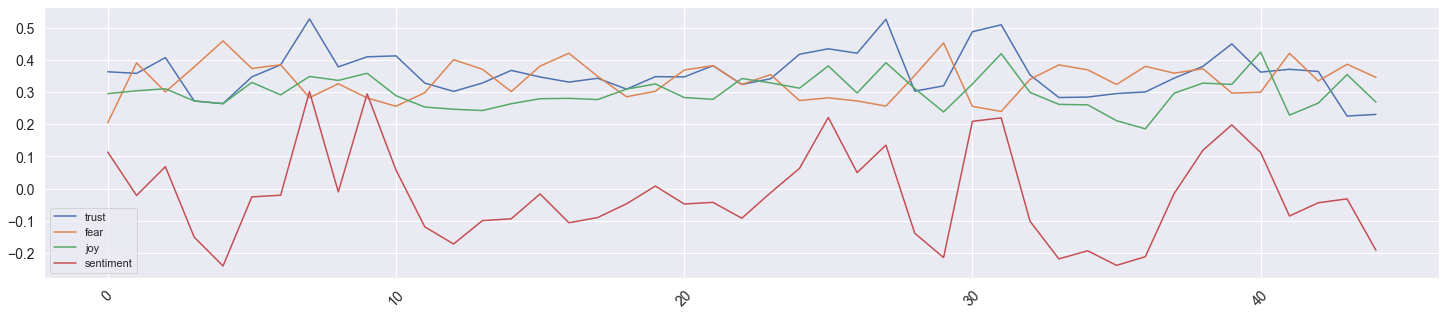

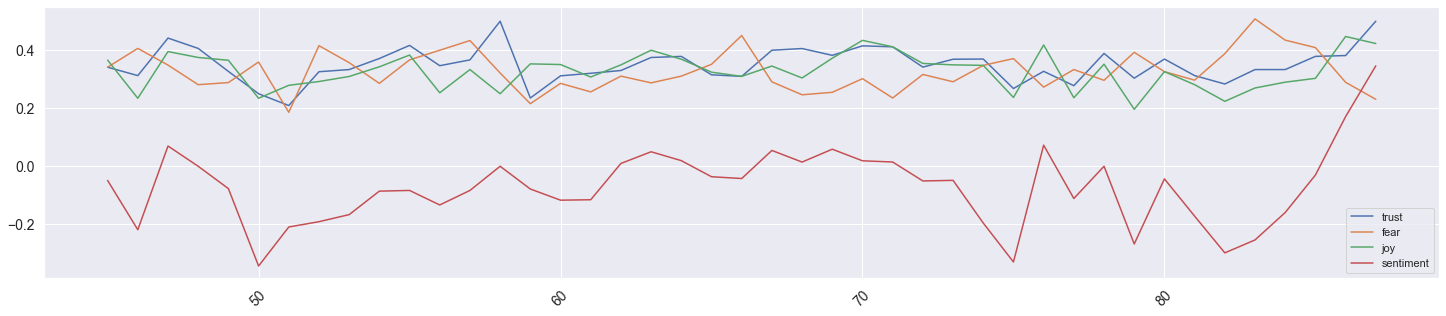

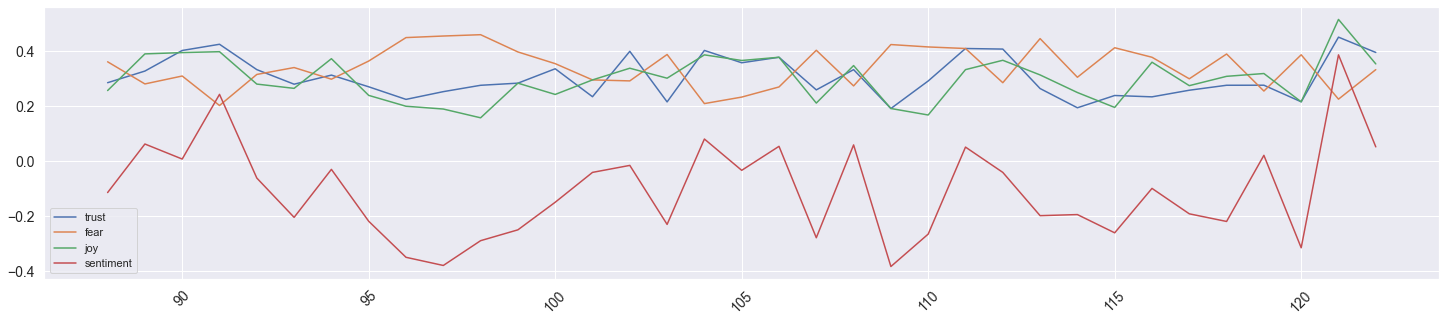

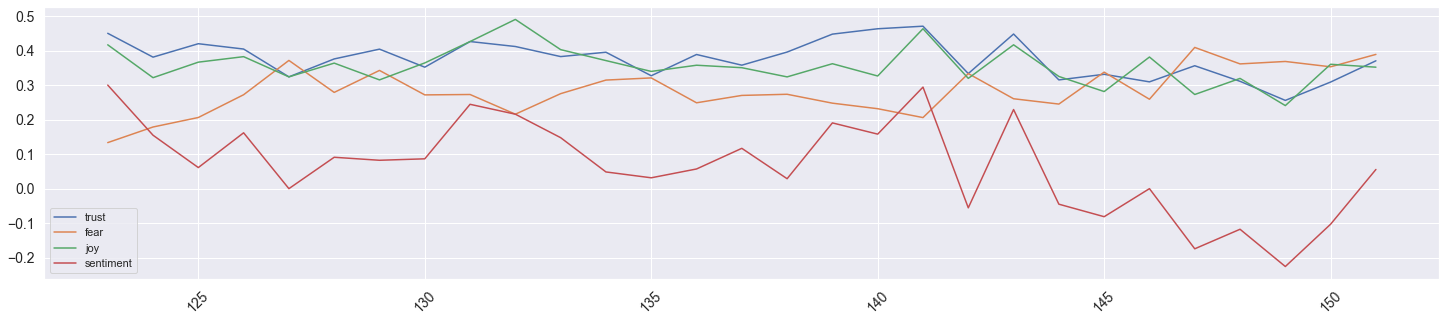

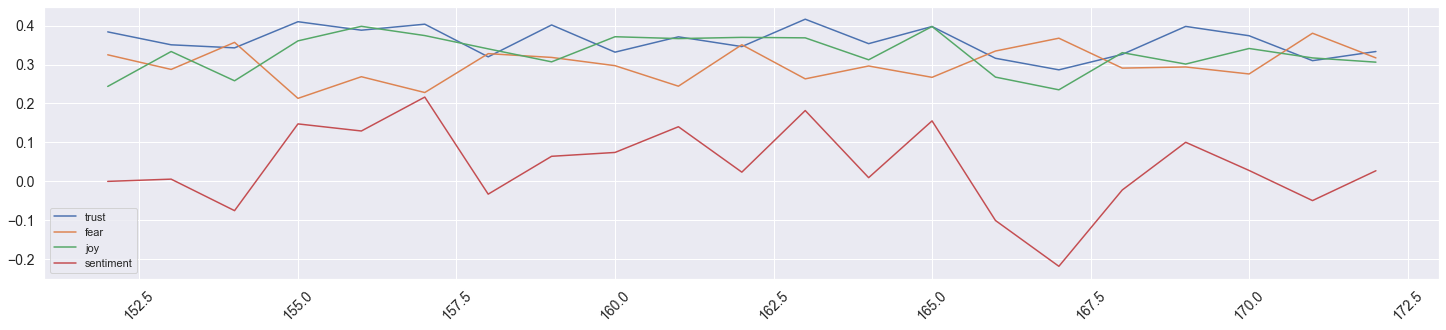

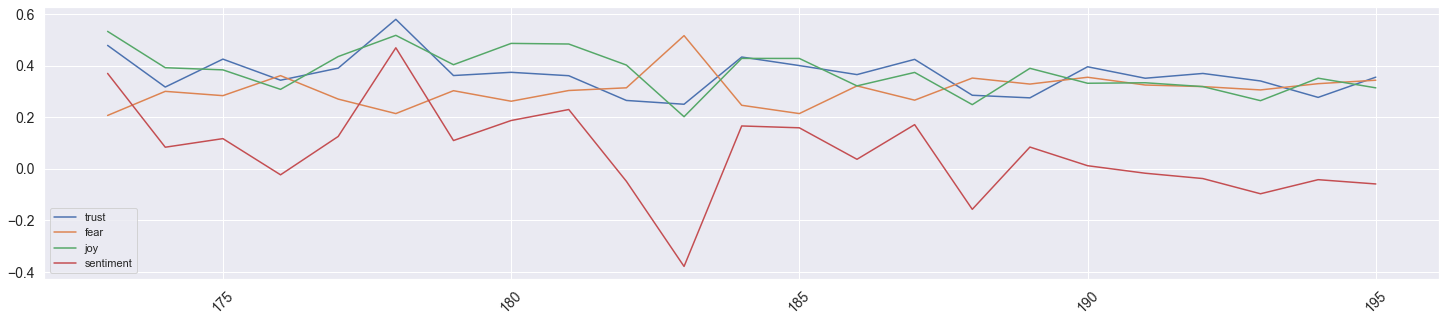

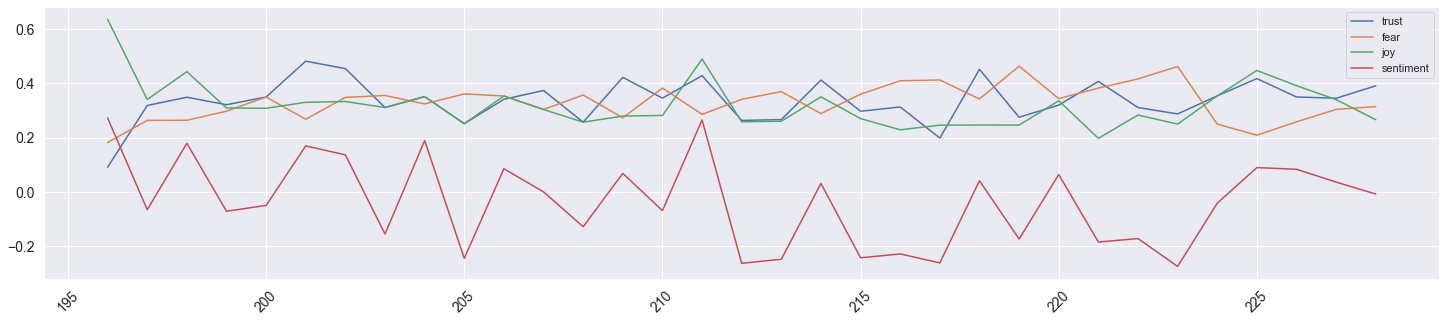

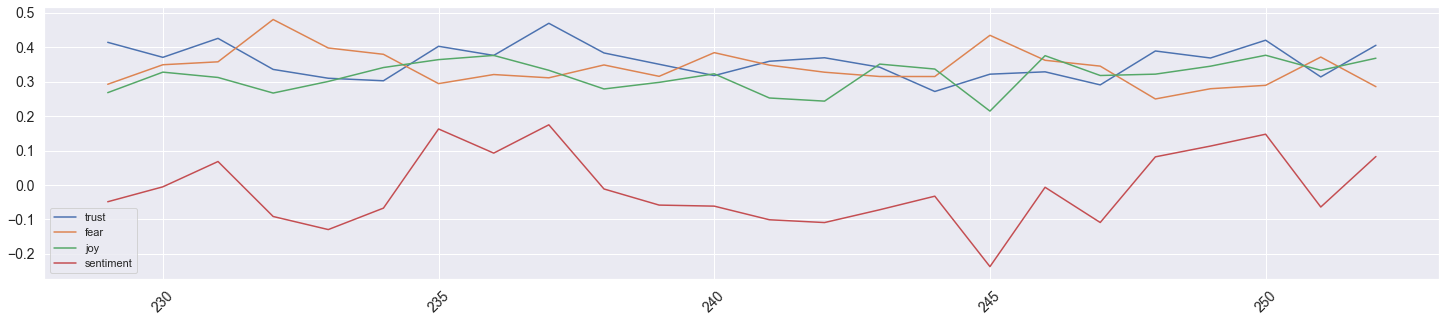

In [137]:
def plot_sentiments(df, emo='sentiment'):
    FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)
    df[emo].plot(**FIG)
    
    
    
plot_sentiments(book_0, ['trust','fear','joy','sentiment'])
plot_sentiments(book_1, ['trust','fear','joy','sentiment'])
plot_sentiments(book_2, ['trust','fear','joy','sentiment'])
plot_sentiments(book_3, ['trust','fear','joy','sentiment'])
plot_sentiments(book_4, ['trust','fear','joy','sentiment'])
plot_sentiments(book_5, ['trust','fear','joy','sentiment'])
plot_sentiments(book_6, ['trust','fear','joy','sentiment'])
plot_sentiments(book_7, ['trust','fear','joy','sentiment'])

## VOCAB_W2V

In [183]:


w2v_params = dict(
    window = 5,
    vector_size = 246,
    min_count = 50, 
    workers = 4
)

import pandas as pd
import numpy as np
from gensim.models import word2vec
from gensim.corpora import Dictionary
from sklearn.manifold import TSNE as tsne
import plotly_express as px
import gensim


docs = CORPUS[~CORPUS.pos.str.match('NNPS?')].dropna(subset=['term_str'])\
    .groupby(OHCO[:2])\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
docs = [doc for doc in docs if len(doc) > 1]

In [184]:
vocab_w2v = Dictionary(docs)
model = word2vec.Word2Vec(docs, **w2v_params)
def get_vector(row):
    w = row.name
    try:
        vec = model.wv[w]
    except KeyError as e:
        vec = None
    return vec

WV = pd.DataFrame(VOCAB.apply(get_vector, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)
WV

0         1         2         3         4         5    \
term_str                                                               
         -0.135030  0.252106 -0.116648  0.036061  0.016460  0.118121   
a        -0.363807 -0.204218  0.196429  0.223581 -0.148848 -0.391173   
able     -0.100702 -0.108325  0.077194  0.062081 -0.002141 -0.129744   
about    -0.186630  0.130227 -0.371540  0.321906 -0.060885 -0.364981   
above     0.204248 -0.239825 -0.145792  0.071771 -0.055917 -0.259209   
...            ...       ...       ...       ...       ...       ...   
your     -0.243038  0.499127 -0.038526 -0.269932 -0.214464  1.150520   
youre    -0.119313  0.158779 -0.080335 -0.013187 -0.019195  0.040292   
yourself -0.197132  0.231548 -0.031093 -0.031085 -0.027702  0.186821   
youth     0.054660 -0.130709 -0.056919  0.053360 -0.025112 -0.204162   
youve    -0.027631 -0.027540 -0.043223  0.049043 -0.031195 -0.157561   

               6         7         8         9    ...       236       237  \
term_str                                          ...                       
         -0.029677 -0.058803  0.194587 -0.102331  ... -0.264880  0.283848   
a         0.424425 -0.126408 -0.188415  0.087226  ...  0.366321 -0.546613   
able     -0.161937 -0.132436 -0.084334 -0.075245  ... -0.248492  0.096765   
about    -0.034056 -0.267265 -0.338412 -0.018940  ... -0.341239  0.248897   
above     0.049853 -0.056549 -0.433014  0.035114  ...  0.074883  0.069259   
...            ...       ...       ...       ...  ...       ...       ...   
your      0.368312  0.227687  0.395527 -0.459833  ... -0.366686  0.552397   
youre    -0.110062 -0.141182  0.061504 -0.142496  ... -0.257646  0.277026   
yourself -0.138323 -0.086888  0.187315 -0.160190  ... -0.370401  0.336939   
youth    -0.071452 -0.091727 -0.135104 -0.076786  ... -0.068680  0.112459   
youve    -0.113472 -0.118100 -0.068785 -0.126236  ... -0.204381  0.137501   

               238       239       240       241       242       243  \
term_str                                                               
         -0.158316  0.305680  0.106472  0.075523  0.031277 -0.086571   
a        -0.039187 -0.321823  0.179152 -0.053694 -0.020950  0.191012   
able     -0.101688  0.067951 -0.188646 -0.054267 -0.005294  0.111315   
about    -0.263532  0.107185  0.268752 -0.389317  0.026333 -0.187829   
above     0.073382 -0.066508  0.153412 -0.200417  0.131577 -0.105763   
...            ...       ...       ...       ...       ...       ...   
your     -0.105887  0.615295  0.302669  0.666196  0.133092 -0.617586   
youre    -0.143969  0.271680  0.069772  0.002201  0.028137 -0.030908   
yourself -0.139566  0.364930 -0.022238  0.053171  0.007135 -0.048438   
youth    -0.035298  0.031046  0.067909 -0.122339  0.046267  0.001703   
youve    -0.036269  0.118213 -0.039867 -0.119619  0.052756  0.031812   

               244       245  
term_str                      
         -0.151922 -0.108333  
a         0.047232 -0.121620  
able      0.006644  0.011786  
about     0.205533  0.323970  
above     0.292865  0.112550  
...            ...       ...  
your     -0.557233 -0.334425  
youre    -0.150608  0.004115  
yourself -0.185454 -0.030872  
youth     0.143804  0.032735  
youve     0.083814  0.046354  

[1243 rows x 246 columns]

## Word2vec tSNE Plot

In [185]:
tsne_engine = tsne(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_model = tsne_engine.fit_transform(WV.to_numpy())
TSNE = pd.DataFrame(tsne_model, columns=['x','y'], index=WV.index)
TSNE

x          y
term_str                      
          38.400997  -5.868387
a         -0.711821 -16.008453
able      25.810280   3.027678
about    -35.947384   9.527759
above    -31.598780   3.748564
...             ...        ...
your      41.697998  -9.865738
youre     34.285412  -2.717292
yourself  36.826538  -2.666305
youth      0.931417  -0.935426
youve     25.780020  -0.279539

[1243 rows x 2 columns]

In [192]:
VOCAB_2 = VOCAB.copy()
VOCAB_2 = VOCAB_2[VOCAB_2.max_pos.isin(['NN','NNS'])]
X = TSNE.join(VOCAB_2, how='left')
px.scatter(X.reset_index(), 'x', 'y', 
           text='term_str', 
           color='max_pos', 
           hover_name='term_str',          
           size='n',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

In [189]:
WV

0         1         2         3         4         5    \
term_str                                                               
         -0.135030  0.252106 -0.116648  0.036061  0.016460  0.118121   
a        -0.363807 -0.204218  0.196429  0.223581 -0.148848 -0.391173   
able     -0.100702 -0.108325  0.077194  0.062081 -0.002141 -0.129744   
about    -0.186630  0.130227 -0.371540  0.321906 -0.060885 -0.364981   
above     0.204248 -0.239825 -0.145792  0.071771 -0.055917 -0.259209   
...            ...       ...       ...       ...       ...       ...   
your     -0.243038  0.499127 -0.038526 -0.269932 -0.214464  1.150520   
youre    -0.119313  0.158779 -0.080335 -0.013187 -0.019195  0.040292   
yourself -0.197132  0.231548 -0.031093 -0.031085 -0.027702  0.186821   
youth     0.054660 -0.130709 -0.056919  0.053360 -0.025112 -0.204162   
youve    -0.027631 -0.027540 -0.043223  0.049043 -0.031195 -0.157561   

               6         7         8         9    ...       236       237  \
term_str                                          ...                       
         -0.029677 -0.058803  0.194587 -0.102331  ... -0.264880  0.283848   
a         0.424425 -0.126408 -0.188415  0.087226  ...  0.366321 -0.546613   
able     -0.161937 -0.132436 -0.084334 -0.075245  ... -0.248492  0.096765   
about    -0.034056 -0.267265 -0.338412 -0.018940  ... -0.341239  0.248897   
above     0.049853 -0.056549 -0.433014  0.035114  ...  0.074883  0.069259   
...            ...       ...       ...       ...  ...       ...       ...   
your      0.368312  0.227687  0.395527 -0.459833  ... -0.366686  0.552397   
youre    -0.110062 -0.141182  0.061504 -0.142496  ... -0.257646  0.277026   
yourself -0.138323 -0.086888  0.187315 -0.160190  ... -0.370401  0.336939   
youth    -0.071452 -0.091727 -0.135104 -0.076786  ... -0.068680  0.112459   
youve    -0.113472 -0.118100 -0.068785 -0.126236  ... -0.204381  0.137501   

               238       239       240       241       242       243  \
term_str                                                               
         -0.158316  0.305680  0.106472  0.075523  0.031277 -0.086571   
a        -0.039187 -0.321823  0.179152 -0.053694 -0.020950  0.191012   
able     -0.101688  0.067951 -0.188646 -0.054267 -0.005294  0.111315   
about    -0.263532  0.107185  0.268752 -0.389317  0.026333 -0.187829   
above     0.073382 -0.066508  0.153412 -0.200417  0.131577 -0.105763   
...            ...       ...       ...       ...       ...       ...   
your     -0.105887  0.615295  0.302669  0.666196  0.133092 -0.617586   
youre    -0.143969  0.271680  0.069772  0.002201  0.028137 -0.030908   
yourself -0.139566  0.364930 -0.022238  0.053171  0.007135 -0.048438   
youth    -0.035298  0.031046  0.067909 -0.122339  0.046267  0.001703   
youve    -0.036269  0.118213 -0.039867 -0.119619  0.052756  0.031812   

               244       245  
term_str                      
         -0.151922 -0.108333  
a         0.047232 -0.121620  
able      0.006644  0.011786  
about     0.205533  0.323970  
above     0.292865  0.112550  
...            ...       ...  
your     -0.557233 -0.334425  
youre    -0.150608  0.004115  
yourself -0.185454 -0.030872  
youth     0.143804  0.032735  
youve     0.083814  0.046354  

[1243 rows x 246 columns]

NameError: name 'VOCAB_2' is not defined

# RIFFS

## Hierarchical cluster diagrams

In [74]:
L0 = M.astype('bool').astype('int') # Binary (Pseudo L)
L1 = M.apply(lambda x: x / x.sum(), 1) # Manhattan (Probabilistic)
L2 = M.apply(lambda x: x / norm(x), 1) # Euclidean

PAIRS = M.T.corr().stack().to_frame('correl')
PAIRS.index.names = ['doc_a','doc_b']
PAIRS = PAIRS.query("doc_a > doc_b") 

general_method = 'weighted' # single, complete, average, weighted 
euclidean_method = 'ward' # ward, centroid, median
combos  = [
    (L2, 'euclidean', 'euclidean', euclidean_method),
    (M,  'cosine', 'cosine', euclidean_method),
    (M,  'cityblock', 'cityblock', general_method),
    (L0, 'jaccard', 'jaccard', general_method),
    (L1, 'jensenshannon', 'js', general_method),
]



<Figure size 432x288 with 0 Axes>

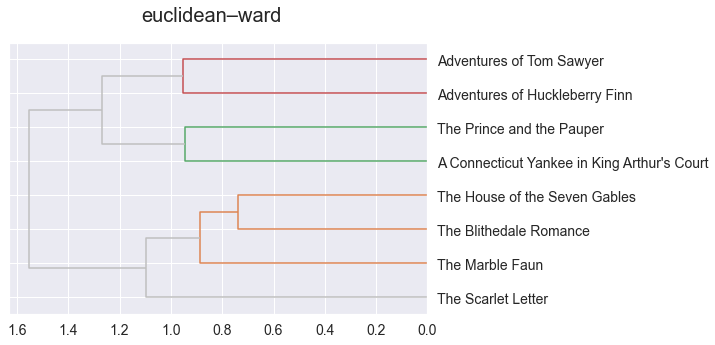

<Figure size 432x288 with 0 Axes>

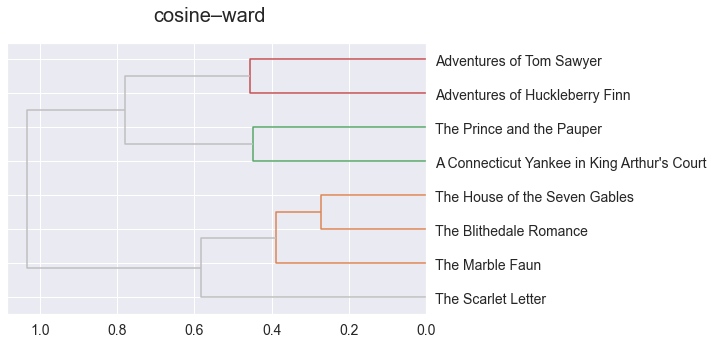

<Figure size 432x288 with 0 Axes>

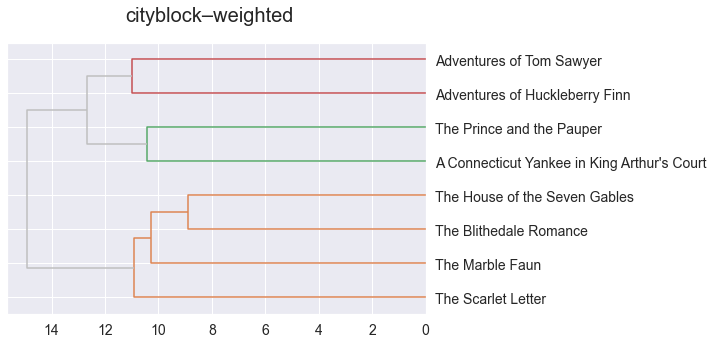

<Figure size 432x288 with 0 Axes>

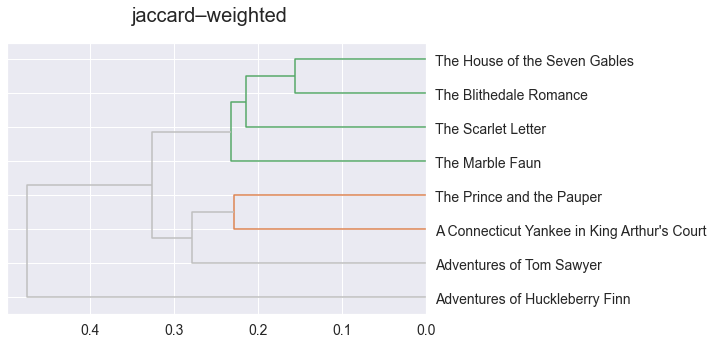

<Figure size 432x288 with 0 Axes>

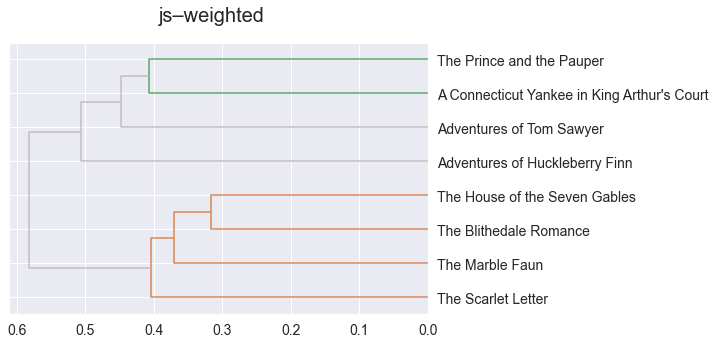

In [91]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
def draw_hca(sims, linkage_method='complete', figsize=(7.5, 5)):
    global LIB
    
    tree = sch.linkage(sims, method=linkage_method)
    color_thresh = pd.DataFrame(tree)[2].mean()
    
    labels = LIB.title.values
    
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh,
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)
    fig.suptitle(f"{label}–{linkage_method}", fontsize=20)
    
for X, metric, label, _ in combos:
    PAIRS[label] = pdist(X, metric)
    
for X, metric, label, linkage in combos:
    #print(PAIRS[label])
    draw_hca(PAIRS[label], linkage_method=linkage)

# RIFF 2

In [76]:
DOC_SENT
result = pd.merge(DOC_SENT.reset_index(), LIB, on="book_id")

In [77]:
# maybe change to add author?
px.scatter(DOC_SENT, "joy", "sadness",
           hover_name=result.reset_index().title,
           color = result.reset_index().author,

           marginal_x='box', marginal_y='box', height=1000)

In [78]:

px.scatter(DOC_SENT, "anticipation", "surprise",
           hover_name=result.reset_index().title,
           color = result.reset_index().author,

           marginal_x='box', marginal_y='box', height=1000)

# RIFF 3

In [97]:
LIB

book_id                                   source_file_path  \
0        0  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
1        1  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
2        2  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
3        3  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
4        4  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
5        5  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
6        6  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   
7        7  /Users/matthewbonner/Desktop/DS5001/data/eta_p...   

                                         title     author  \
0  A Connecticut Yankee in King Arthur's Court      TWAIN   
1               Adventures of Huckleberry Finn      TWAIN   
2                     Adventures of Tom Sawyer      TWAIN   
3                       The Blithedale Romance  HAWTHORNE   
4                The House of the Seven Gables  HAWTHORNE   
5                              The Marble Faun  HAWTHORNE   
6                    The Prince and the Pauper      TWAIN   
7                           The Scarlet Letter  HAWTHORNE   

                                          chap_regex  date  n_chaps  
0  (\bCHAPTER\s*[IVXLCDM]+\b|THE END OF THE MANUS...  1889       45  
1      (^\s*CHAPTER\s*[IVXLCDM]+\.|CHAPTER THE LAST)  1884       43  
2                           ^\s*CHAPTER\s*[IVXLCDM]+  1876       35  
3                                 ^[IVXLCM]+\.\s*.*$  1852       29  
4                                 ^\s*[IVXLCM]+\s*.$  1851       21  
5                         ^\s*CHAPTER\s[IVXLCM]+\s*$  1860       23  
6              (^\s*CHAPTER\s*[IVXLCDM]+|CONCLUSION)  1881       33  
7                                 ^\s*[IVXLCM]+\s*.$  1850       24

In [107]:
TWAIN[TWAIN.term_str == 'scarlet']

book_id  chap_id  para_num  sent_num  token_num       pos_tuple pos  \
553784        6        9         3         7         68   (scarlet, NN)  NN   
553798        6        9         3         7         82  (scarlet,, NN)  NN   
553812        6        9         3         7         96   (scarlet, NN)  NN   
557350        6       11         3         0         25   (scarlet, NN)  NN   
568844        6       15        15         0          3  (scarlet,, NN)  NN   
572338        6       16         8         0          9  (scarlet,, NN)  NN   
610110        6       33       112         1          6   (scarlet, NN)  NN   

       token_str term_str pos_group author  date  
553784   scarlet  scarlet        NN  TWAIN  1881  
553798  scarlet,  scarlet        NN  TWAIN  1881  
553812   scarlet  scarlet        NN  TWAIN  1881  
557350   scarlet  scarlet        NN  TWAIN  1881  
568844  scarlet,  scarlet        NN  TWAIN  1881  
572338  scarlet,  scarlet        NN  TWAIN  1881  
610110   scarlet  scarlet        NN  TWAIN  1881

In [79]:
result3 = pd.merge(CORPUS.reset_index(), LIB, on="book_id")

In [80]:
result3 = result3.drop(columns = ["source_file_path", "chap_regex", "n_chaps", "title"])

In [81]:
TWAIN = result3[result3.author == "TWAIN"]
HAWTHORNE = result3[result3.author == "HAWTHORNE"]

In [82]:
docs_t = TWAIN[~TWAIN.pos.str.match('NNPS?')].dropna(subset=['term_str'])\
    .groupby(OHCO[:2])\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
docs_t = [doc for doc in docs_t if len(doc) > 1]

docs_h = HAWTHORNE[~HAWTHORNE.pos.str.match('NNPS?')].dropna(subset=['term_str'])\
    .groupby(OHCO[:2])\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
docs_h = [doc for doc in docs_h if len(doc) > 1]

In [128]:
vocab_w2v_t = Dictionary(docs_t)
model_t = word2vec.Word2Vec(docs_t, **w2v_params)
def get_vector_t(row):
    w = row.name
    try:
        vec = model_t.wv[w]
    except KeyError as e:
        vec = None
    return vec
model_h = word2vec.Word2Vec(docs_h, **w2v_params)
def get_vector_h(row):
    w = row.name
    try:
        vec = model_h.wv[w]
    except KeyError as e:
        vec = None
    return vec
vocab_w2v_h = Dictionary(docs_h)



In [129]:
VOCAB_t = TWAIN.term_str.value_counts().to_frame('n').sort_index()
VOCAB_t.index.name = 'term_str'
VOCAB_t['n_chars'] = VOCAB_t.index.str.len()
VOCAB_t['p'] = VOCAB_t.n / VOCAB_t.n.sum()
VOCAB_t['i'] = -np.log2(VOCAB_t.p)
VOCAB_t['max_pos'] = TWAIN[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)
bits = []
for i in range(len(VOCAB_t['max_pos'])):
    bits.append(VOCAB_t['max_pos'][i][:2])
    
VOCAB_t['max_pos_group'] = bits

VOCAB_h = HAWTHORNE.term_str.value_counts().to_frame('n').sort_index()
VOCAB_h.index.name = 'term_str'
VOCAB_h['n_chars'] = VOCAB_h.index.str.len()
VOCAB_h['p'] = VOCAB_h.n / VOCAB_h.n.sum()
VOCAB_h['i'] = -np.log2(VOCAB_h.p)
VOCAB_h['max_pos'] = HAWTHORNE[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)
bits = []
for i in range(len(VOCAB_h['max_pos'])):
    bits.append(VOCAB_h['max_pos'][i][:2])
    
VOCAB_h['max_pos_group'] = bits

In [130]:
#model_t = word2vec.Word2Vec(docs_t, **w2v_params)
WV_t = pd.DataFrame(VOCAB_t.apply(get_vector_t, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)
#model_h = word2vec.Word2Vec(docs_h, **w2v_params)
WV_h = pd.DataFrame(VOCAB_h.apply(get_vector_h, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)

In [131]:
tsne_engine = tsne(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_model_t = tsne_engine.fit_transform(WV_t.to_numpy())
TSNE_t = pd.DataFrame(tsne_model_t, columns=['x','y'], index=WV_t.index)

tsne_model_h = tsne_engine.fit_transform(WV_h.to_numpy())
TSNE_h = pd.DataFrame(tsne_model_h, columns=['x','y'], index=WV_h.index)



In [125]:
VOCAB_2_t.reset_index()[VOCAB_2_t.reset_index().term_str == 'scarlet']

term_str  n  n_chars         p         i max_pos max_pos_group
6944  scarlet  7        7  0.000019  15.68056      NN            NN

In [132]:
VOCAB_2_t = VOCAB_t.copy()
VOCAB_2_t = VOCAB_2_t[VOCAB_2_t.max_pos.isin(['NN','NNS'])]
X_t = TSNE_t.join(VOCAB_2_t, how='left')
px.scatter(X_t.reset_index(), 'x', 'y', 
           text='term_str', 
           color='max_pos', 
           hover_name='term_str',          
           size='n',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

In [133]:
VOCAB_2_h = VOCAB_h.copy()
VOCAB_2_h = VOCAB_2_h[VOCAB_2_h.max_pos.isin(['NN','NNS'])]
X_h = TSNE_h.join(VOCAB_2_h, how='left')
px.scatter(X_h.reset_index(), 'x', 'y', 
           text='term_str', 
           color='max_pos', 
           hover_name='term_str',          
           size='n',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

## Saving

In [156]:
LIB.to_csv('LIB.csv')

In [177]:
CORPUS.to_csv("CORPUS.csv")

In [181]:
VOCAB.to_csv("VOCAB.csv")

In [192]:
BOW.to_csv("BOW.csv")

In [194]:
DTM.to_csv("DTM.csv")

In [196]:
TFIDF.to_csv("TFIDF.csv")

In [89]:
L2.to_csv("TFIDF_L2.csv")

In [90]:
COMPINF.to_csv("COMPINF.csv")

In [91]:
DCM.to_csv("DCM.csv")

In [92]:
LOADINGS.to_csv("LOADINGS.csv")

In [117]:
count.to_csv("count.csv")

In [118]:
TOPICS_CHA.to_csv("TOPICS.csv")

In [119]:
THETA_CHA.to_csv("THETA.csv")

In [120]:
PHI_CHA.to_csv("PHI.csv")

In [127]:
SALEX.to_csv("SALEX.csv")

In [128]:
VOCAB_SENT.to_csv("VOCAB_SENT.csv")

In [132]:
BOW_SENT.to_csv("BOW_SENT.csv")

In [135]:
DOC_SENT.to_csv("DOC_SENT.csv")

In [193]:
WV.to_csv("VOCAB_W2V.csv")